In [302]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
from pymatreader import read_mat
import IPython
from pathlib import Path
from utilities import savefig, FKFit, FitInput, FitResult, perform_fit, perform_fit_rounds, num_err_to_latex_str

In [2]:
NB_NAME = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]).stem

In [9]:
DATAPATH = os.path.join(os.path.abspath(""), "data", NB_NAME)

fnames = os.listdir(DATAPATH)
fnames = [os.path.join(DATAPATH, fname) for fname in fnames]
data_dict = {}

freqlist = read_mat(fnames[0])["Data"]["FreqList"]
powerlist = read_mat(fnames[0])["Data"]["PowerList"] * 1e6

for fname in fnames:
    data = read_mat(fname)["Data"]
    VoltageOn = int(data["VoltageOn"])
    resistance = int(data["Resistance"])
    data = {
        "m_freq": data["MeasuredFreq"],
        "counts": data["MeasureCounts"],
        "current": data["MeasureCurrent"] * 1e6,
    }
    if data_dict.get(resistance):
        data_dict[resistance].update({VoltageOn: data})
    else:
        data_dict[resistance] = {VoltageOn: data}
wls = 2.99792458e5 / freqlist

In [4]:
voltages = [0, -2, -4]
resistances = sorted(list(data_dict.keys()))

In [5]:
def plot_2d_maps(data_dict, powerlist, freqlist, voltages, resistances):
    for resistance in resistances:
        print(f"DATA FOR RESISTANCE: {resistance:,}")
        fig, axs = plt.subplots(1, len(voltages), figsize=(6 * len(voltages), 4))
        for j, voltage in enumerate(voltages):
            pcm = axs[j].contourf(
                powerlist,
                freqlist,
                data_dict[resistance][voltage]["counts"],
                levels=len(freqlist),
            )
            cb = fig.colorbar(pcm, ax=axs[j], pad = 0.01)
            cb.set_label(r"Counts", fontsize=14)
            axs[j].set_xlabel(r"Power [$\mu W$]", fontsize=14)
            axs[j].set_ylabel(r"Frequency [$Thz$]", fontsize=14)
            axs[j].set_title(rf"{voltage}", fontsize=14)
        plt.show()

In [6]:
def plot_power_counts(data_dict, powerlist, freqlist, voltages, resistances):
    if len(voltages) != 3:
        raise ValueError("This function can only be used when we have 3 voltages.")
    for resistance in resistances:
        print(f"DATA FOR RESISTANCE: {resistance:,}")
        fig, axs = plt.subplots(4, 4, figsize=(25, 20))

        for idx, ax in enumerate(axs.ravel()):
            ax.set_title(rf"{freqlist[::2][idx]:.1f} $Thz$", fontsize=15)
            for voltage in voltages:
                ax.plot(powerlist, data_dict[resistance][voltage]["counts"][::2][idx], label=f"{voltage}V")
            ax.legend(frameon=False, fontsize=13)

        fig.text(0.5, 0.06, r'Power [$\mu W$]', ha='center', fontsize=30)
        fig.text(0.09, 0.5, 'Counts', va='center', rotation='vertical', fontsize=30)
        plt.show()

def plot_frequency_counts(data_dict, powerlist, freqlist, voltages, resistances):
    if len(voltages) != 3:
        raise ValueError("This function can only be used when we have 3 voltages.")
    for resistance in resistances:
        print(f"DATA FOR RESISTANCE: {resistance:,}")
        fig, axs = plt.subplots(3, 4, figsize=(21, 12))

        for idx, ax in enumerate(axs.ravel()):
            ax.set_title(rf"{powerlist[::9][idx]:.3f} $\mu W$", fontsize=15)
            for voltage in voltages:
                ax.plot(freqlist, data_dict[resistance][voltage]["counts"][:, ::9][:, idx], label=f"{voltage}V")
            ax.legend(frameon=False, fontsize=13)

        fig.text(0.5, 0.06, r'Frequency [$Thz$]', ha='center', fontsize=30)
        fig.text(0.09, 0.5, 'Counts', va='center', rotation='vertical', fontsize=30)
        plt.show()

def plot_power_counts_with_fit(inputs, results, voltages):

    fig, axs = plt.subplots(4, 4, figsize=(25, 20))

    for idx, ax in enumerate(axs.ravel()):
        ax.set_title(rf"{freqlist[::2][idx]:.1f} $Thz$", fontsize=15)
        for idx1, voltage in enumerate(voltages):
            ax.plot(inputs[idx1][idx].xdata, inputs[idx1][idx].ydata, '.', label=f"Data {voltage}V")
            linspace = np.linspace(np.min(powerlist), np.max(powerlist), 1000)
            ax.plot(linspace, inputs[idx1][idx].fit_func(linspace, *results[idx1][idx].parameters), label=f"Fit {voltage}V", lw=2)
        ax.legend(frameon=False, fontsize=13)

    fig.text(0.5, 0.06, r'Power [$\mu W$]', ha='center', fontsize=30)
    fig.text(0.09, 0.5, 'Counts', va='center', rotation='vertical', fontsize=30)
    plt.show()


DATA FOR RESISTANCE: 0


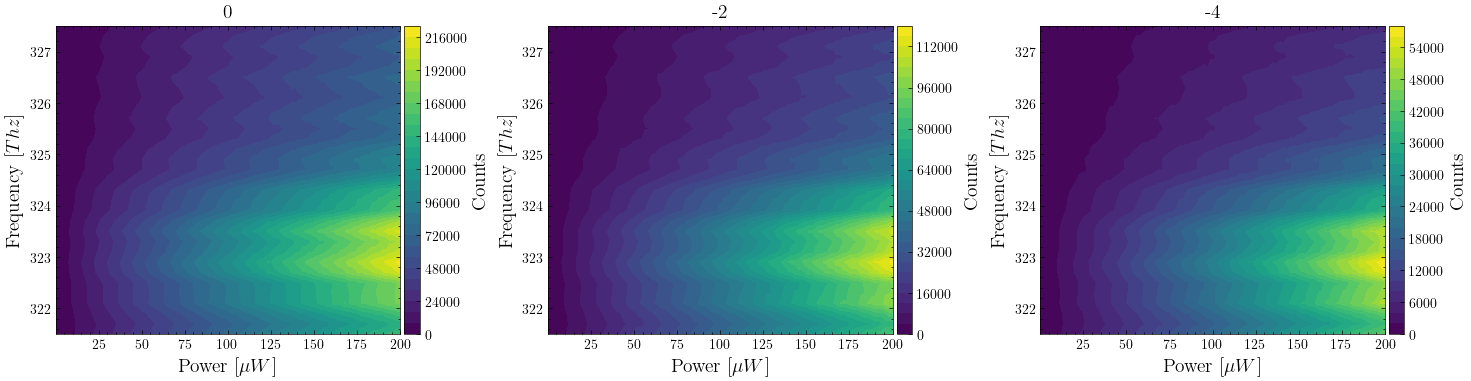

DATA FOR RESISTANCE: 97,500


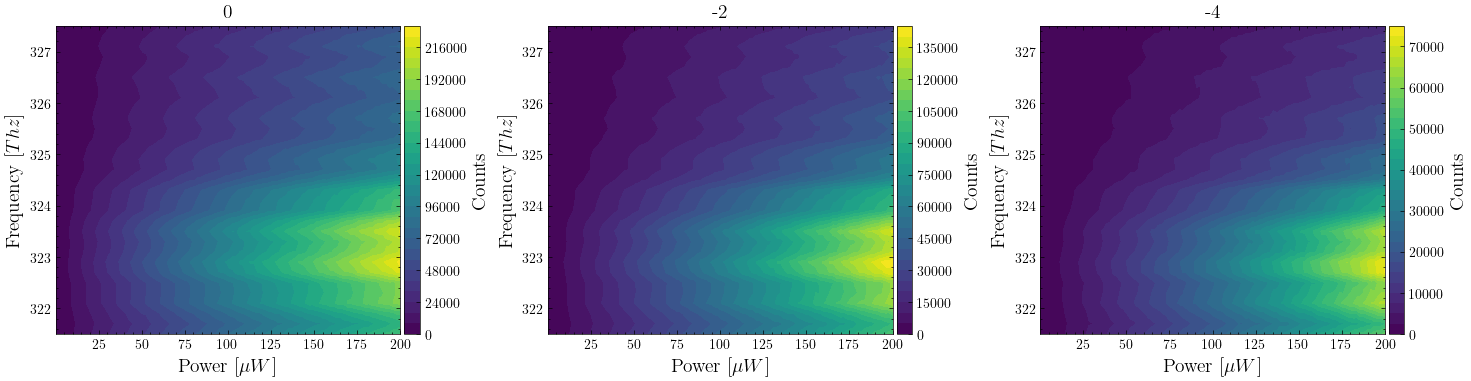

DATA FOR RESISTANCE: 325,300


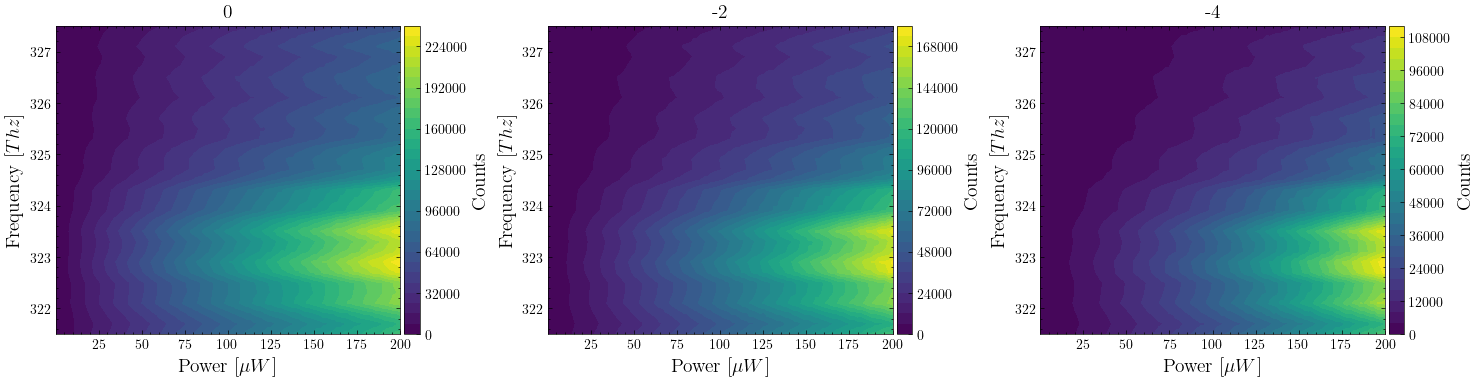

DATA FOR RESISTANCE: 552,000


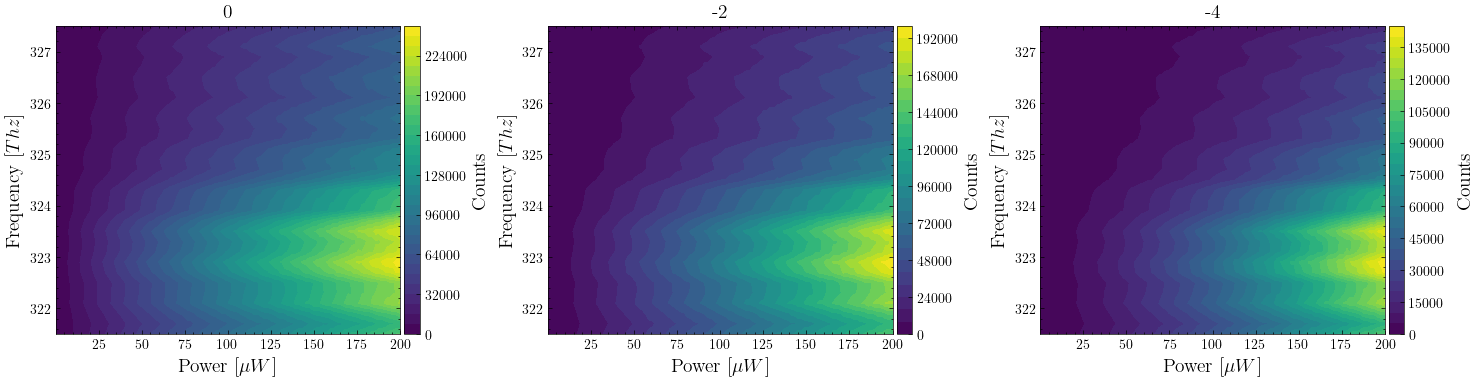

DATA FOR RESISTANCE: 677,000


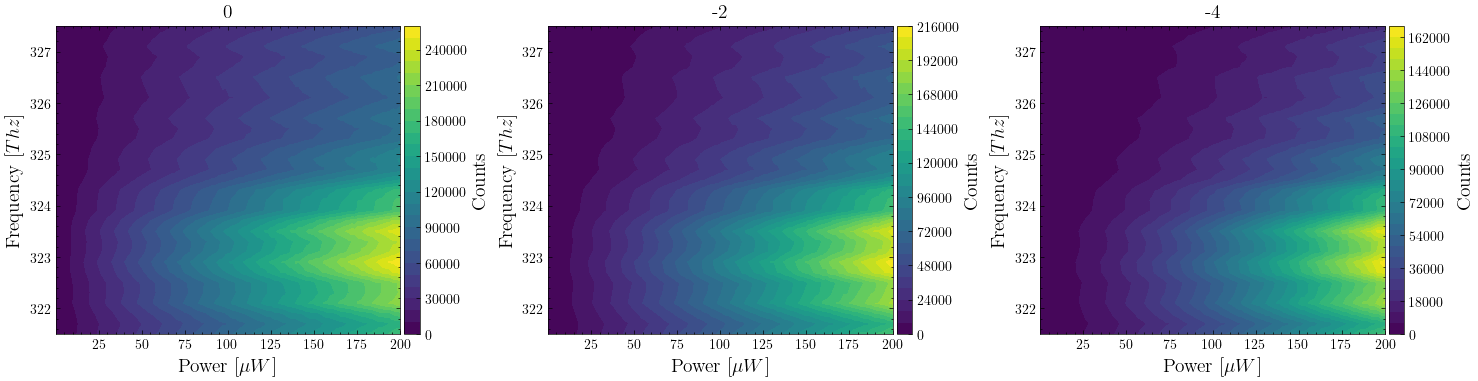

DATA FOR RESISTANCE: 807,000


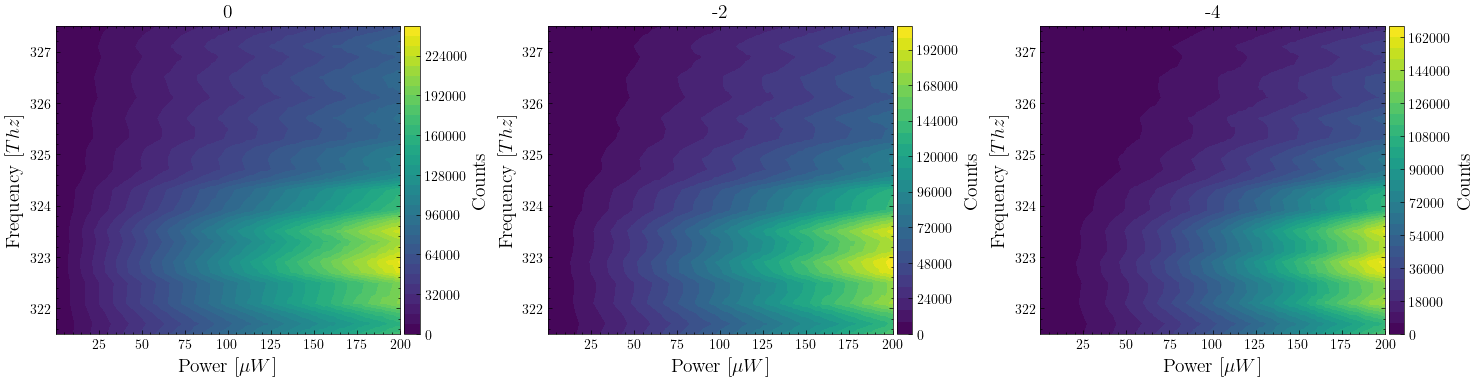

DATA FOR RESISTANCE: 1,000,000


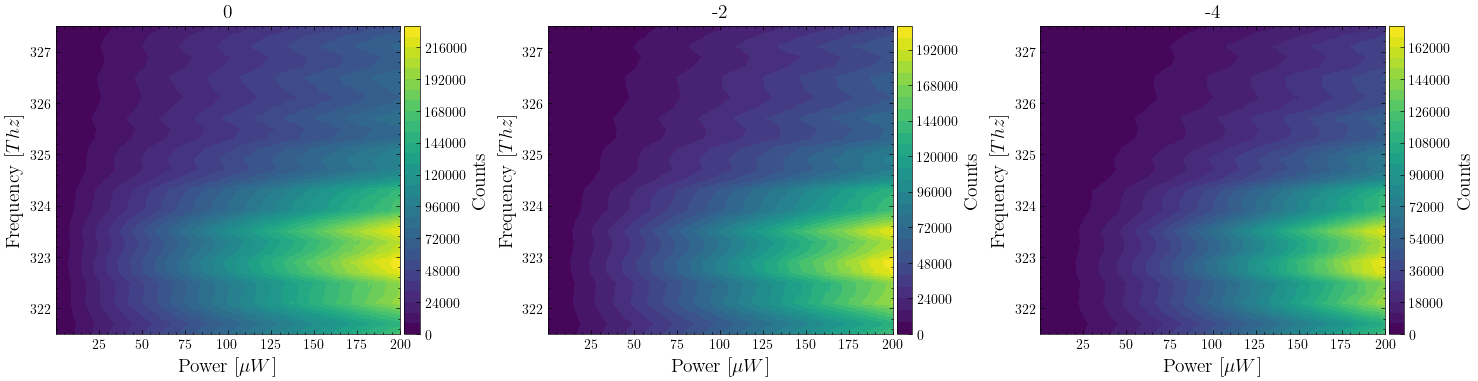

DATA FOR RESISTANCE: 3,012,000


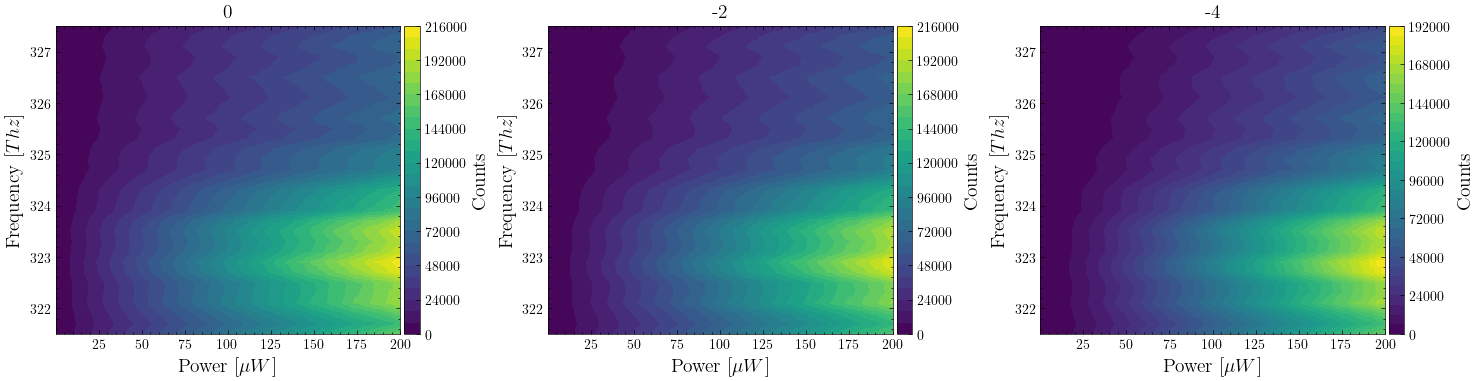

DATA FOR RESISTANCE: 10,000,000


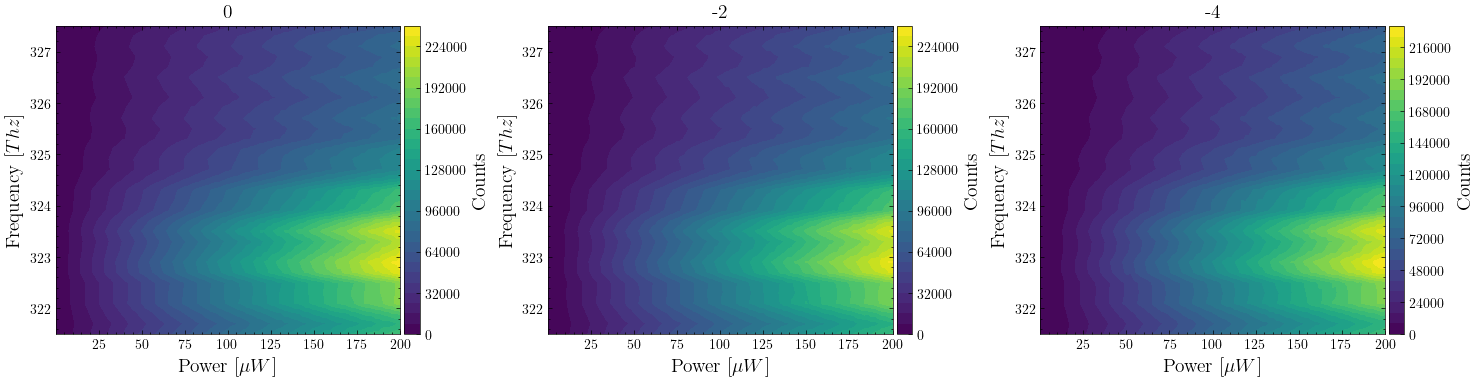

In [7]:
plot_2d_maps(data_dict, powerlist, freqlist, voltages, resistances)

DATA FOR RESISTANCE: 0


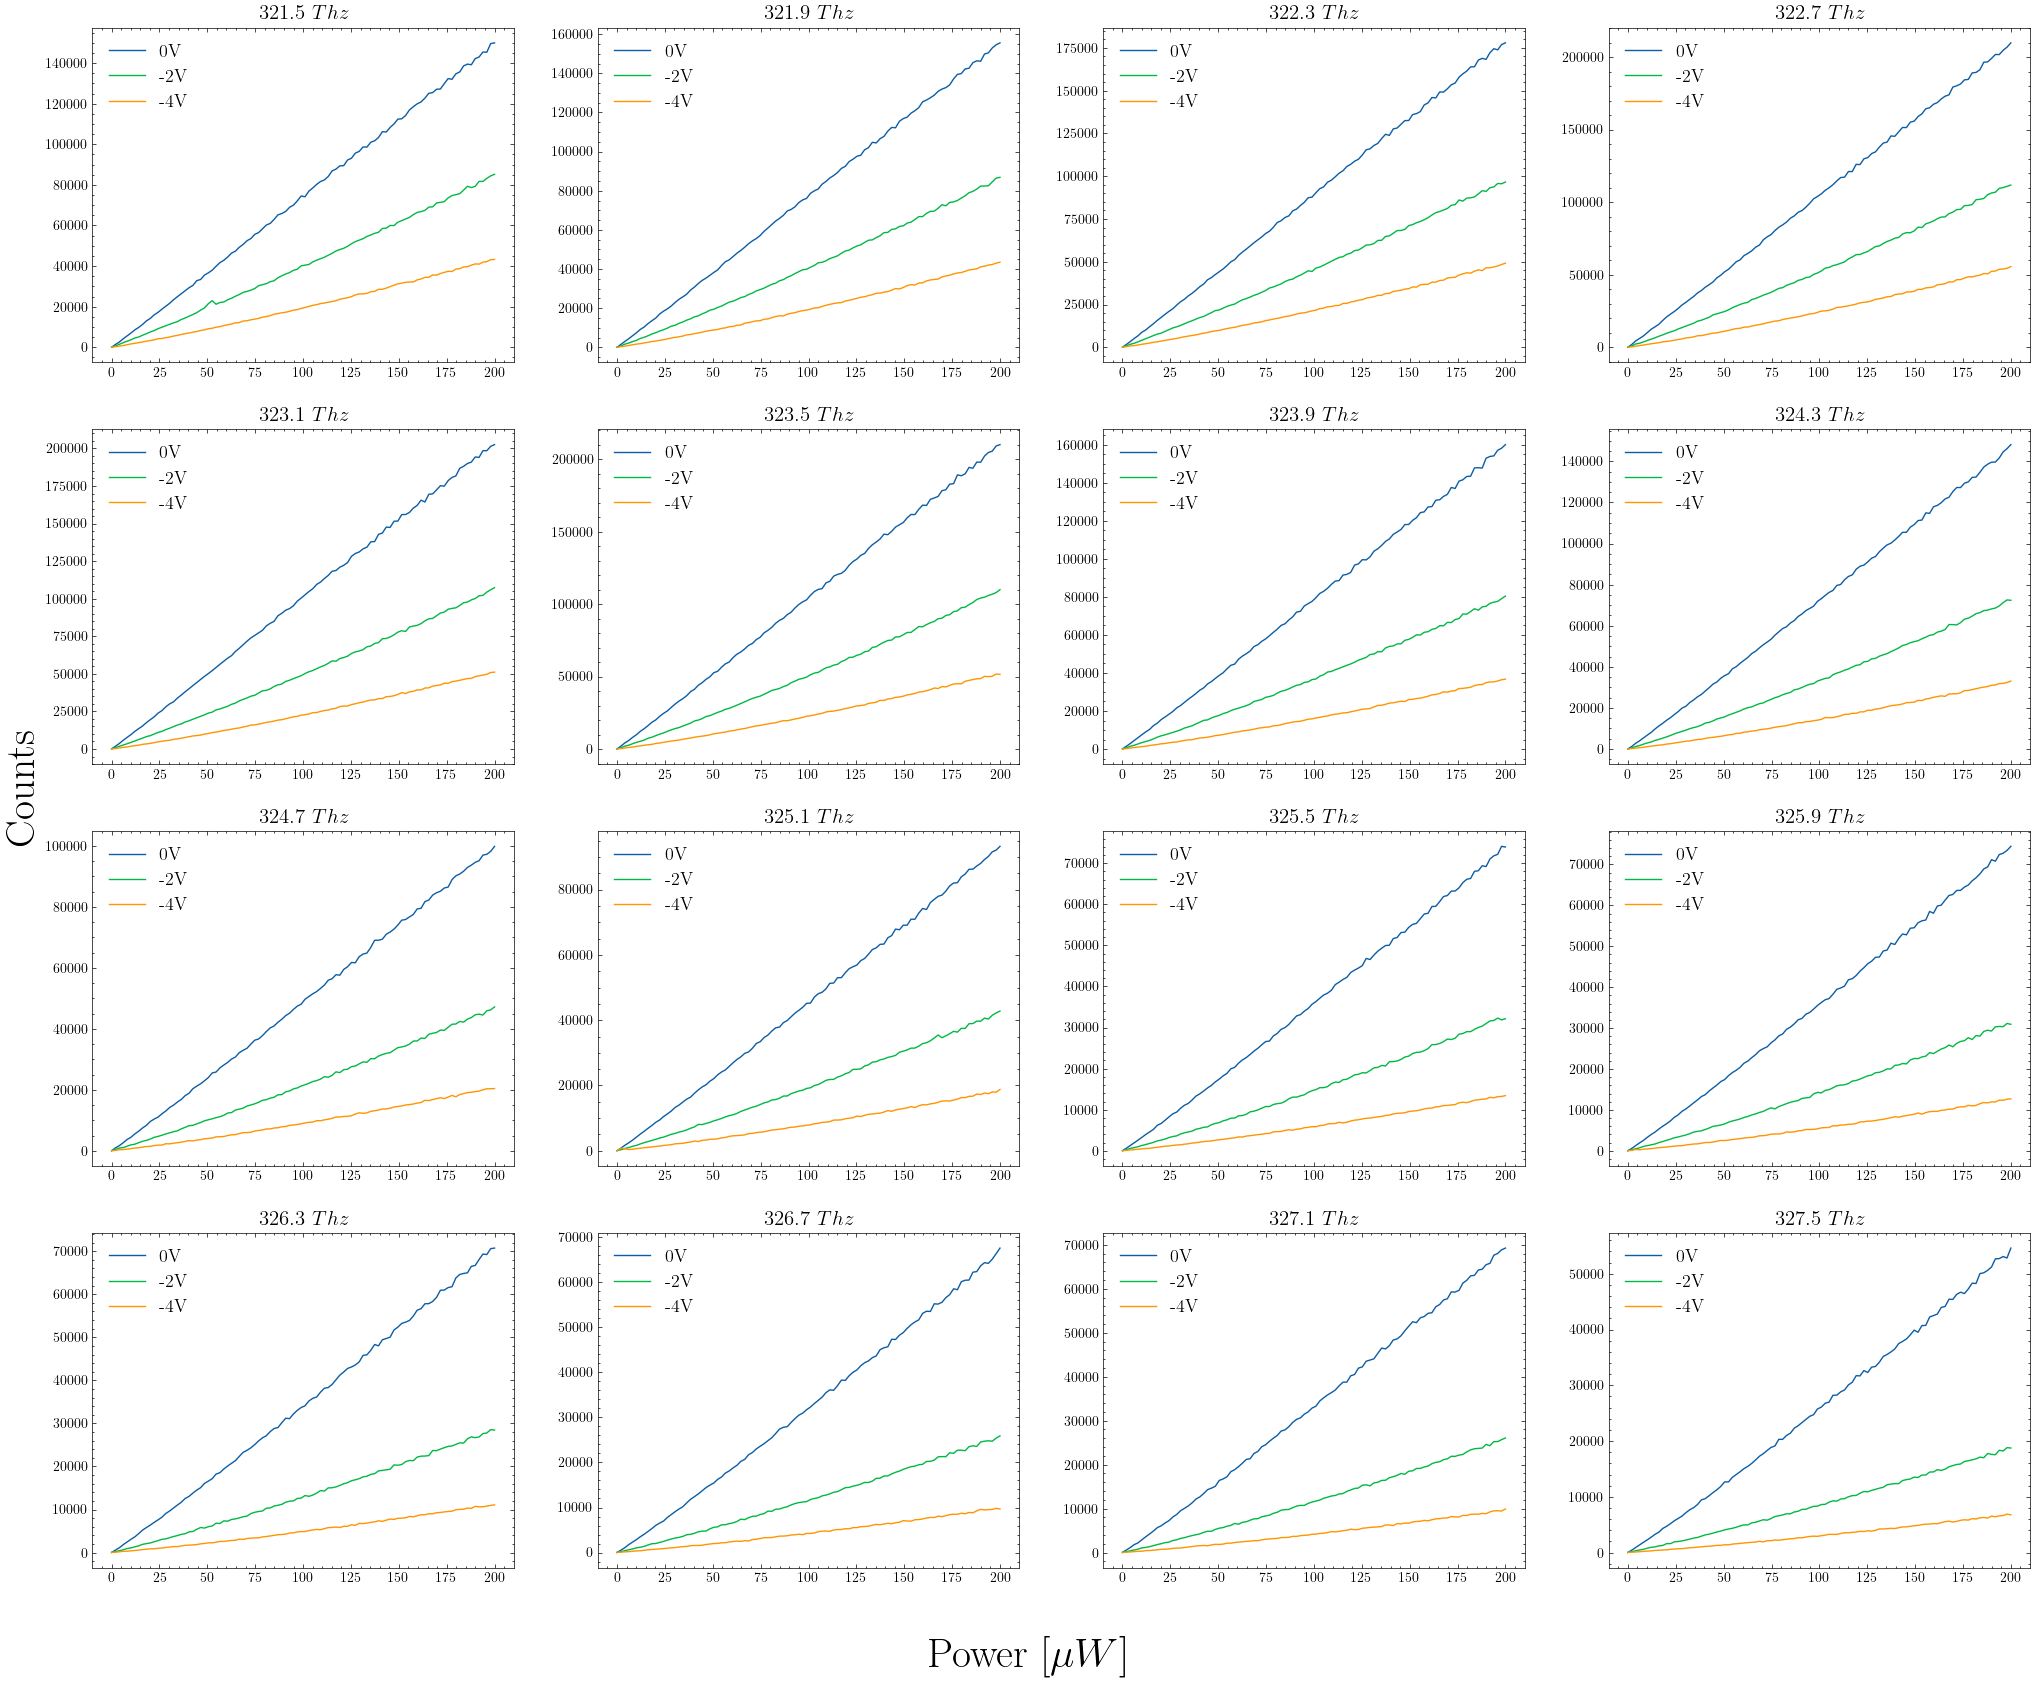

DATA FOR RESISTANCE: 97,500


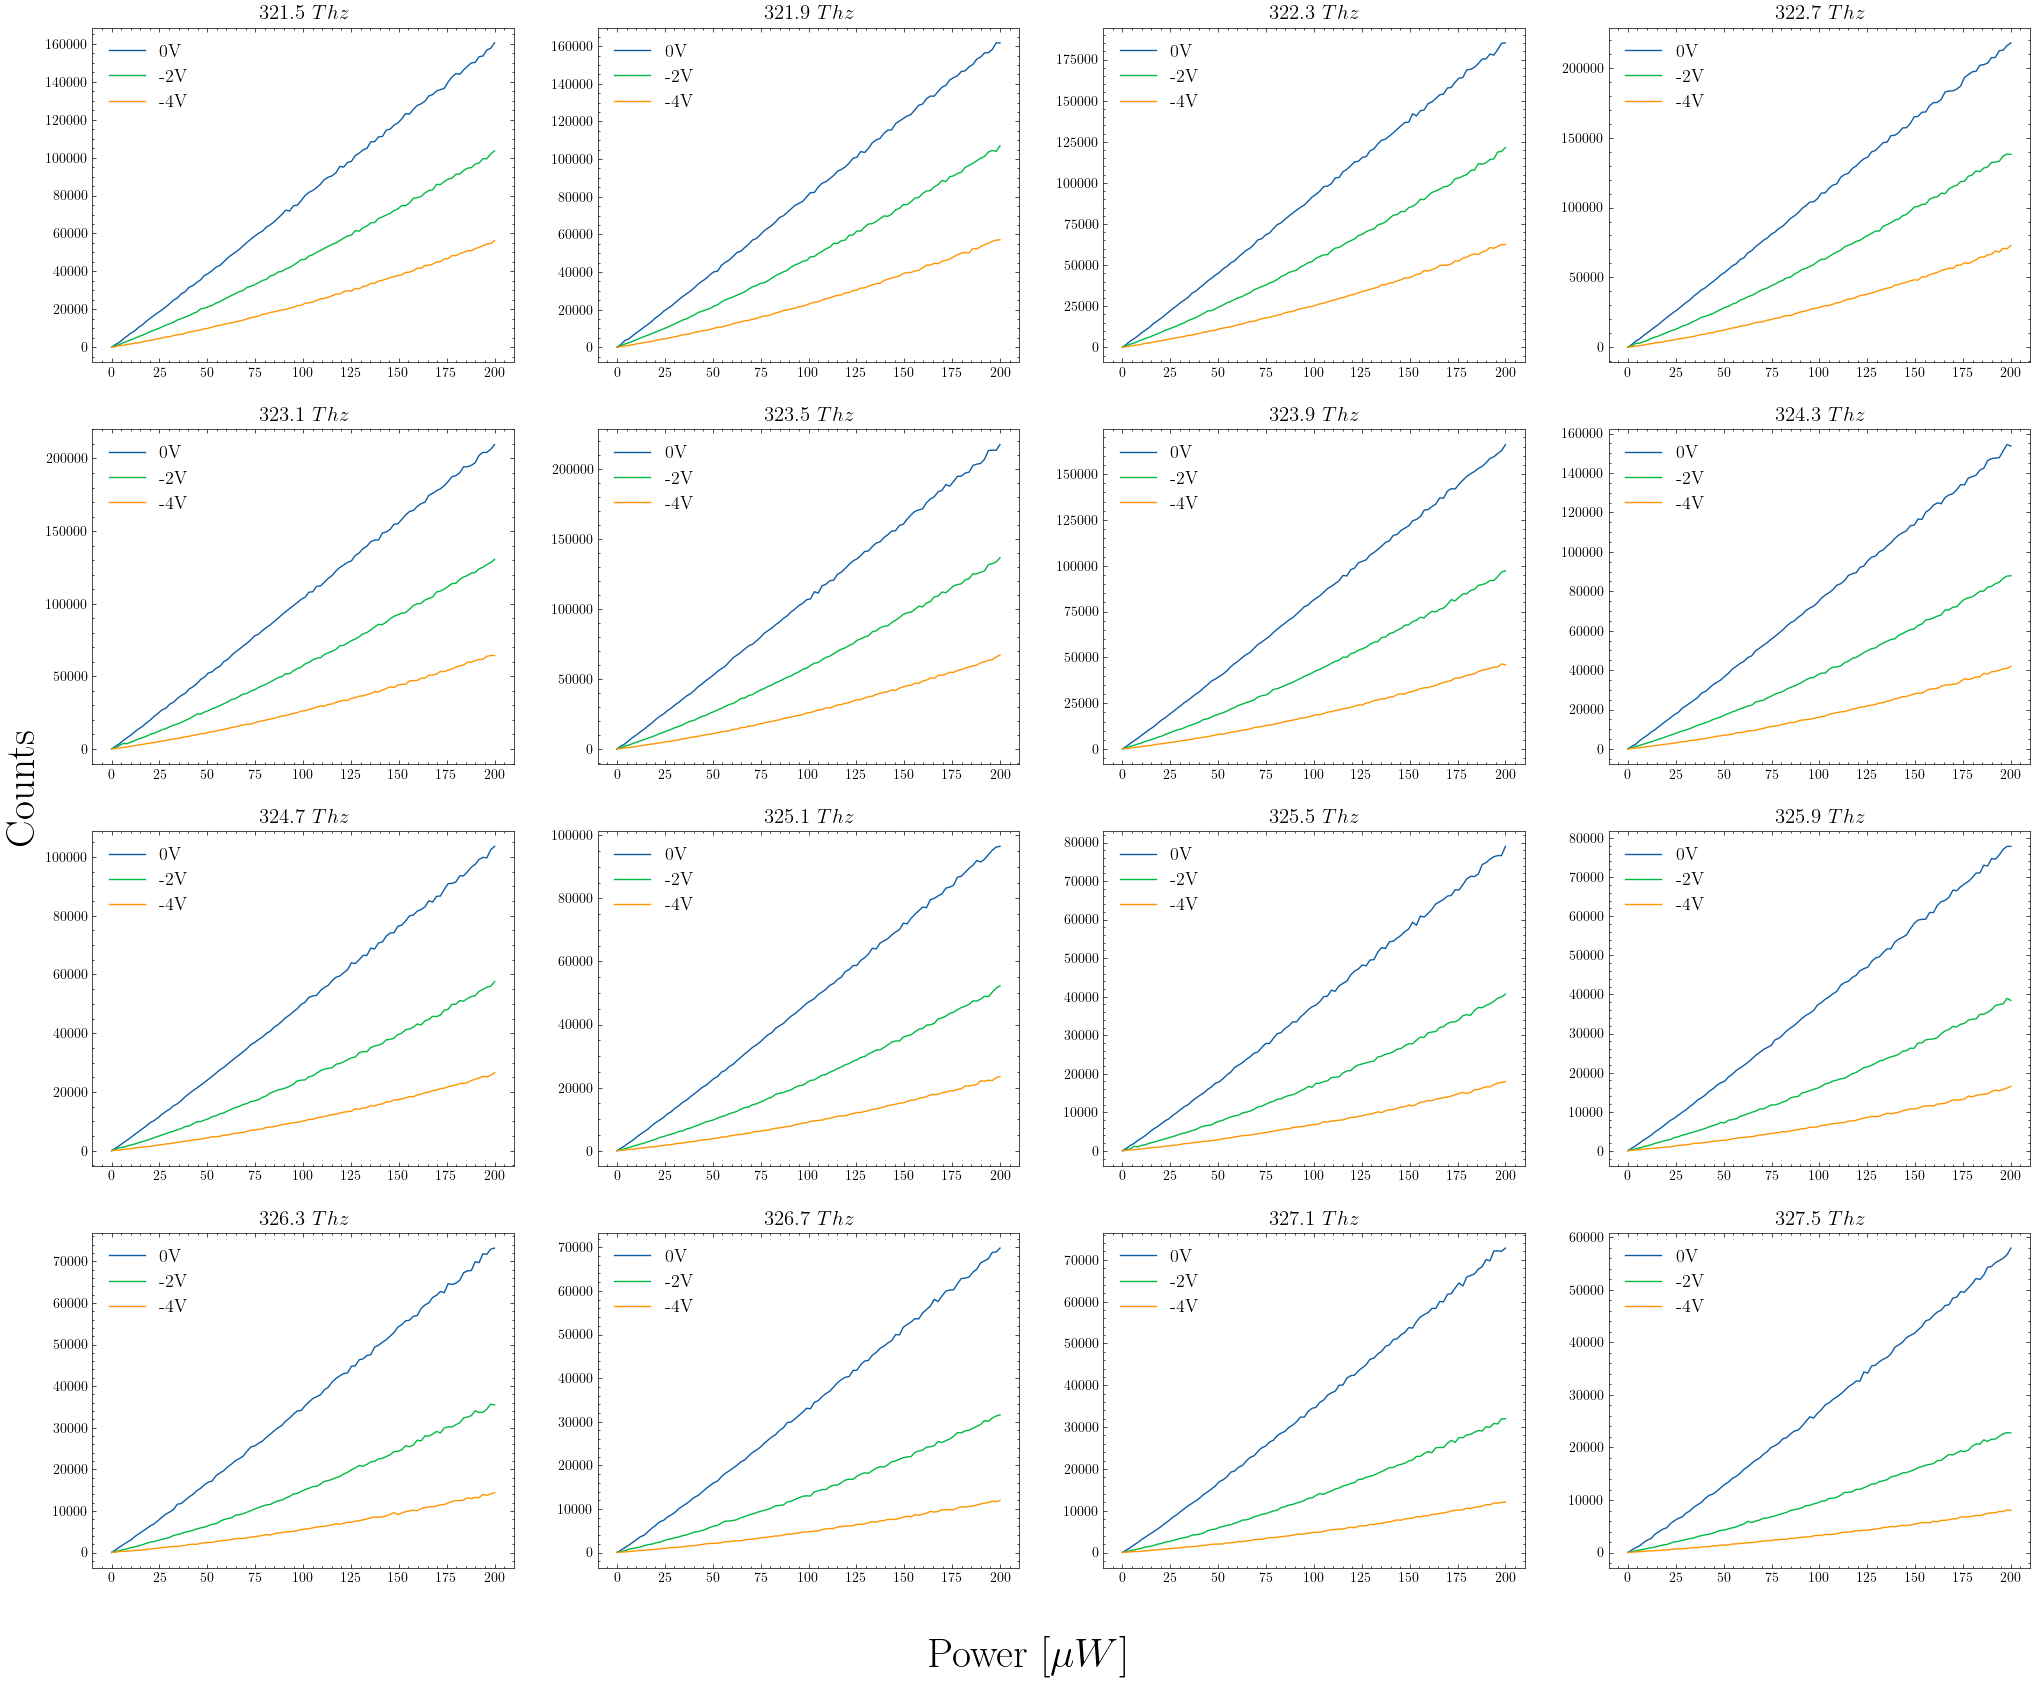

DATA FOR RESISTANCE: 325,300


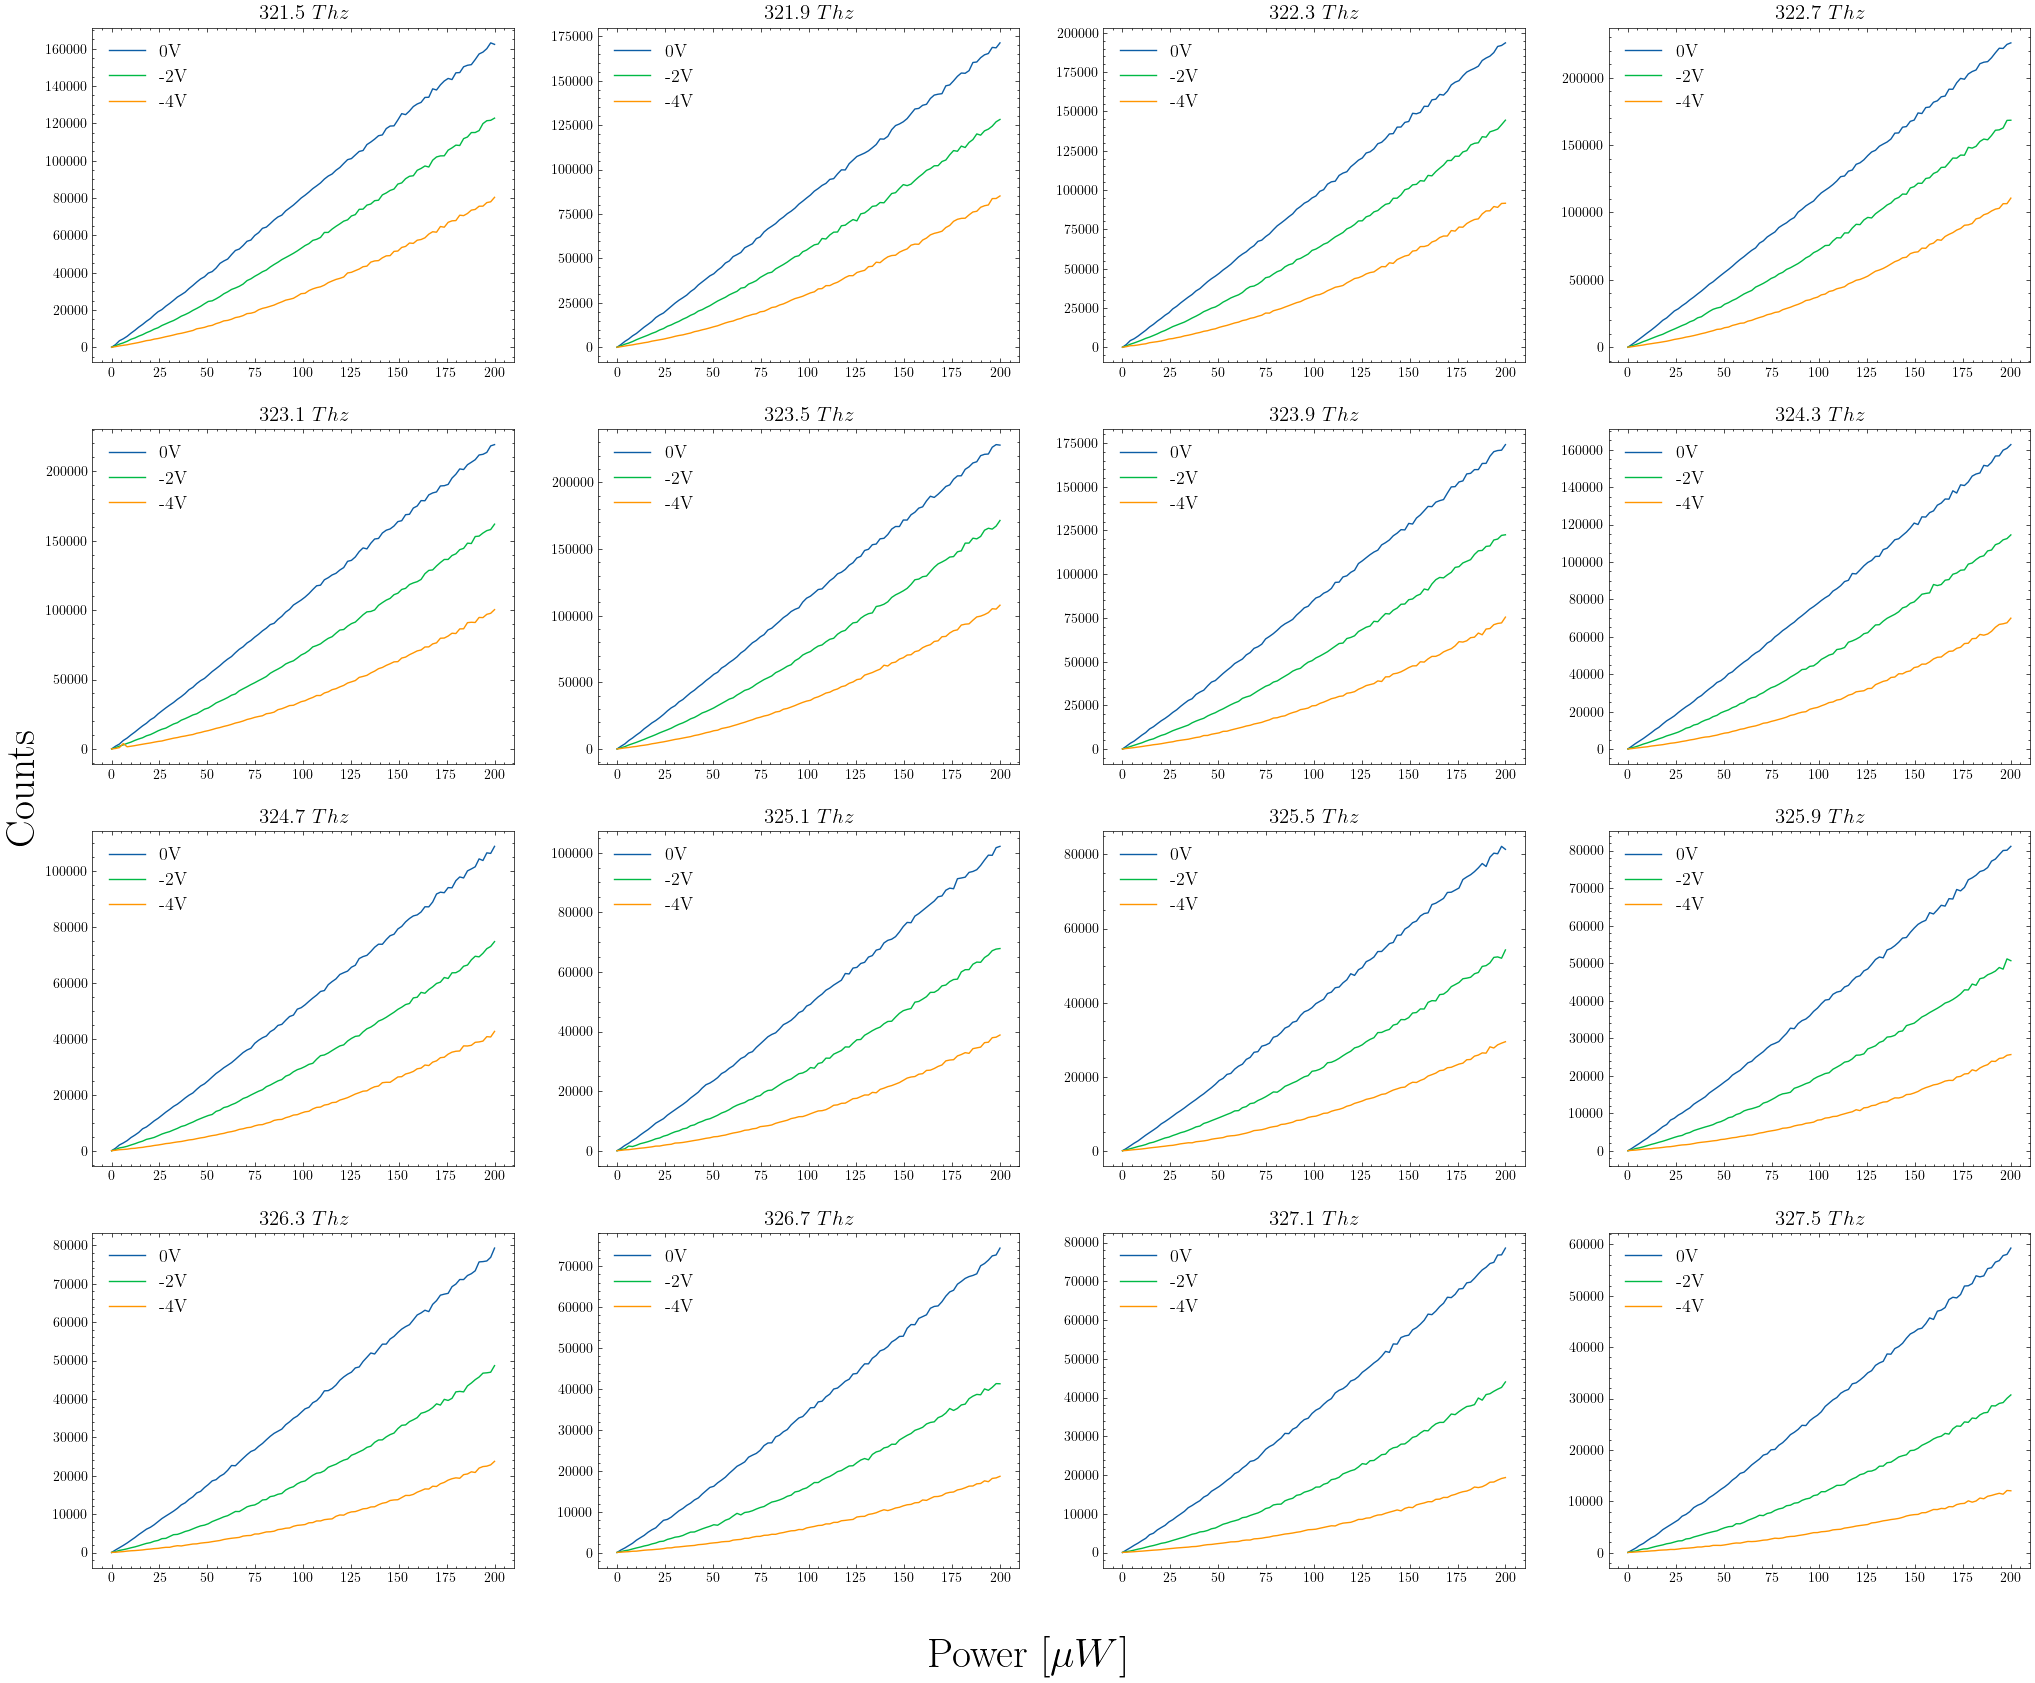

DATA FOR RESISTANCE: 552,000


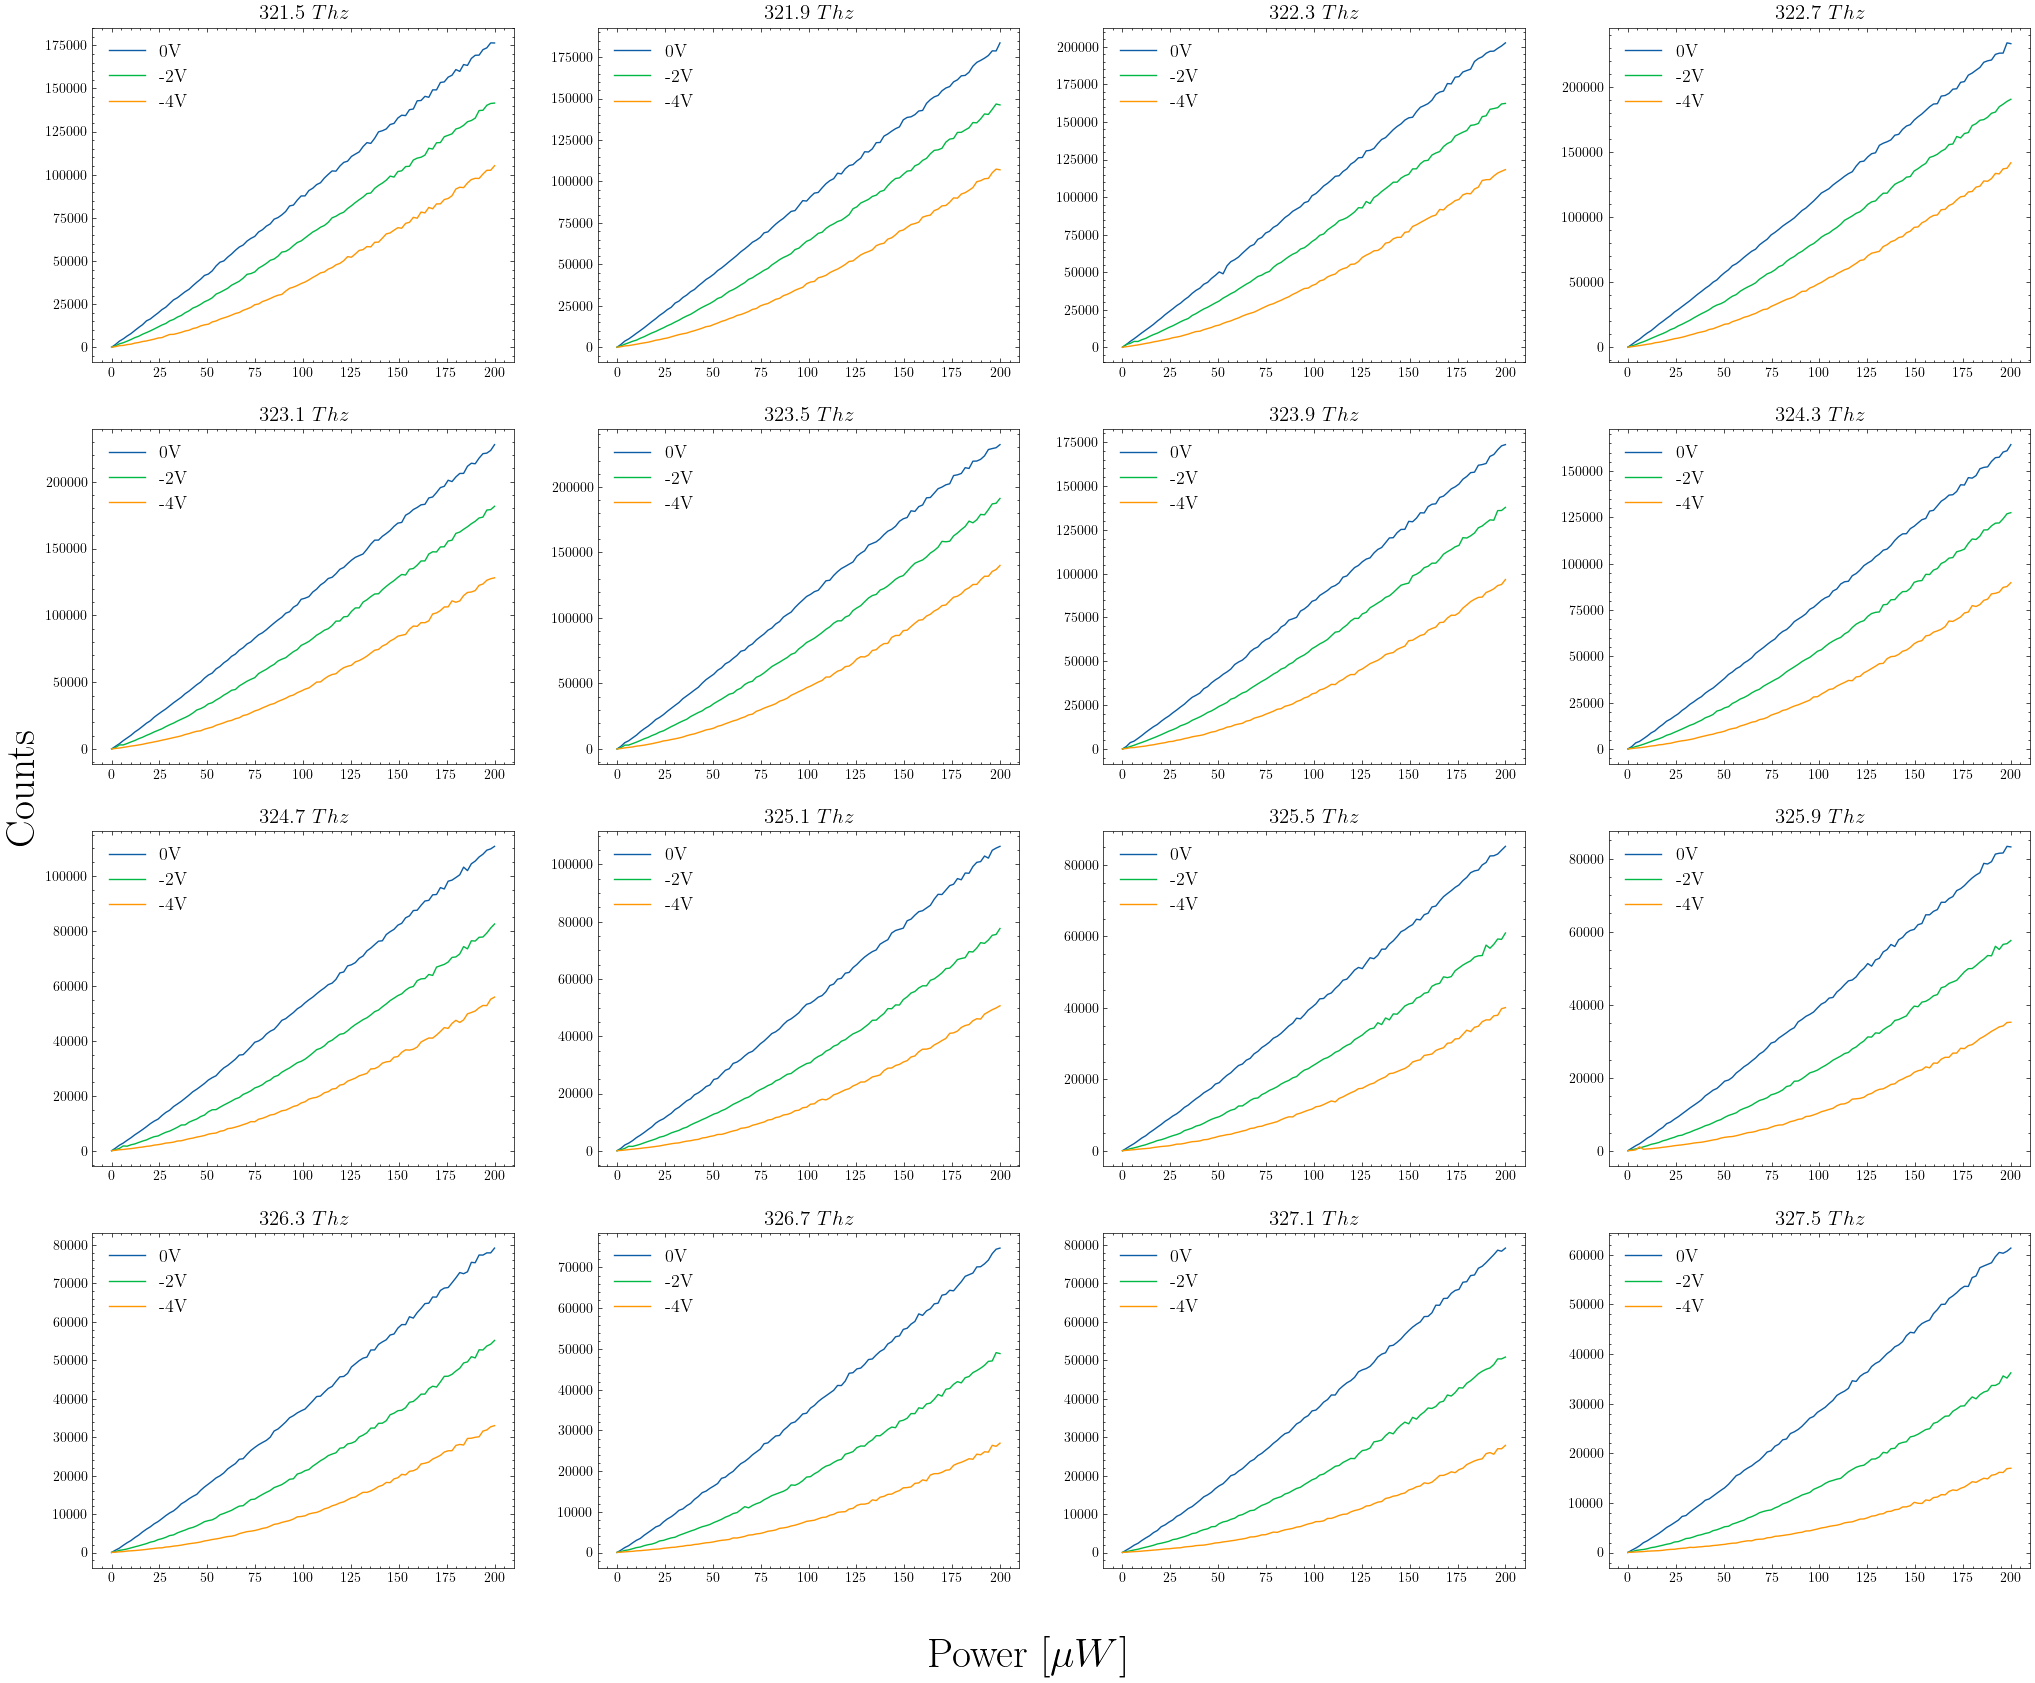

DATA FOR RESISTANCE: 677,000


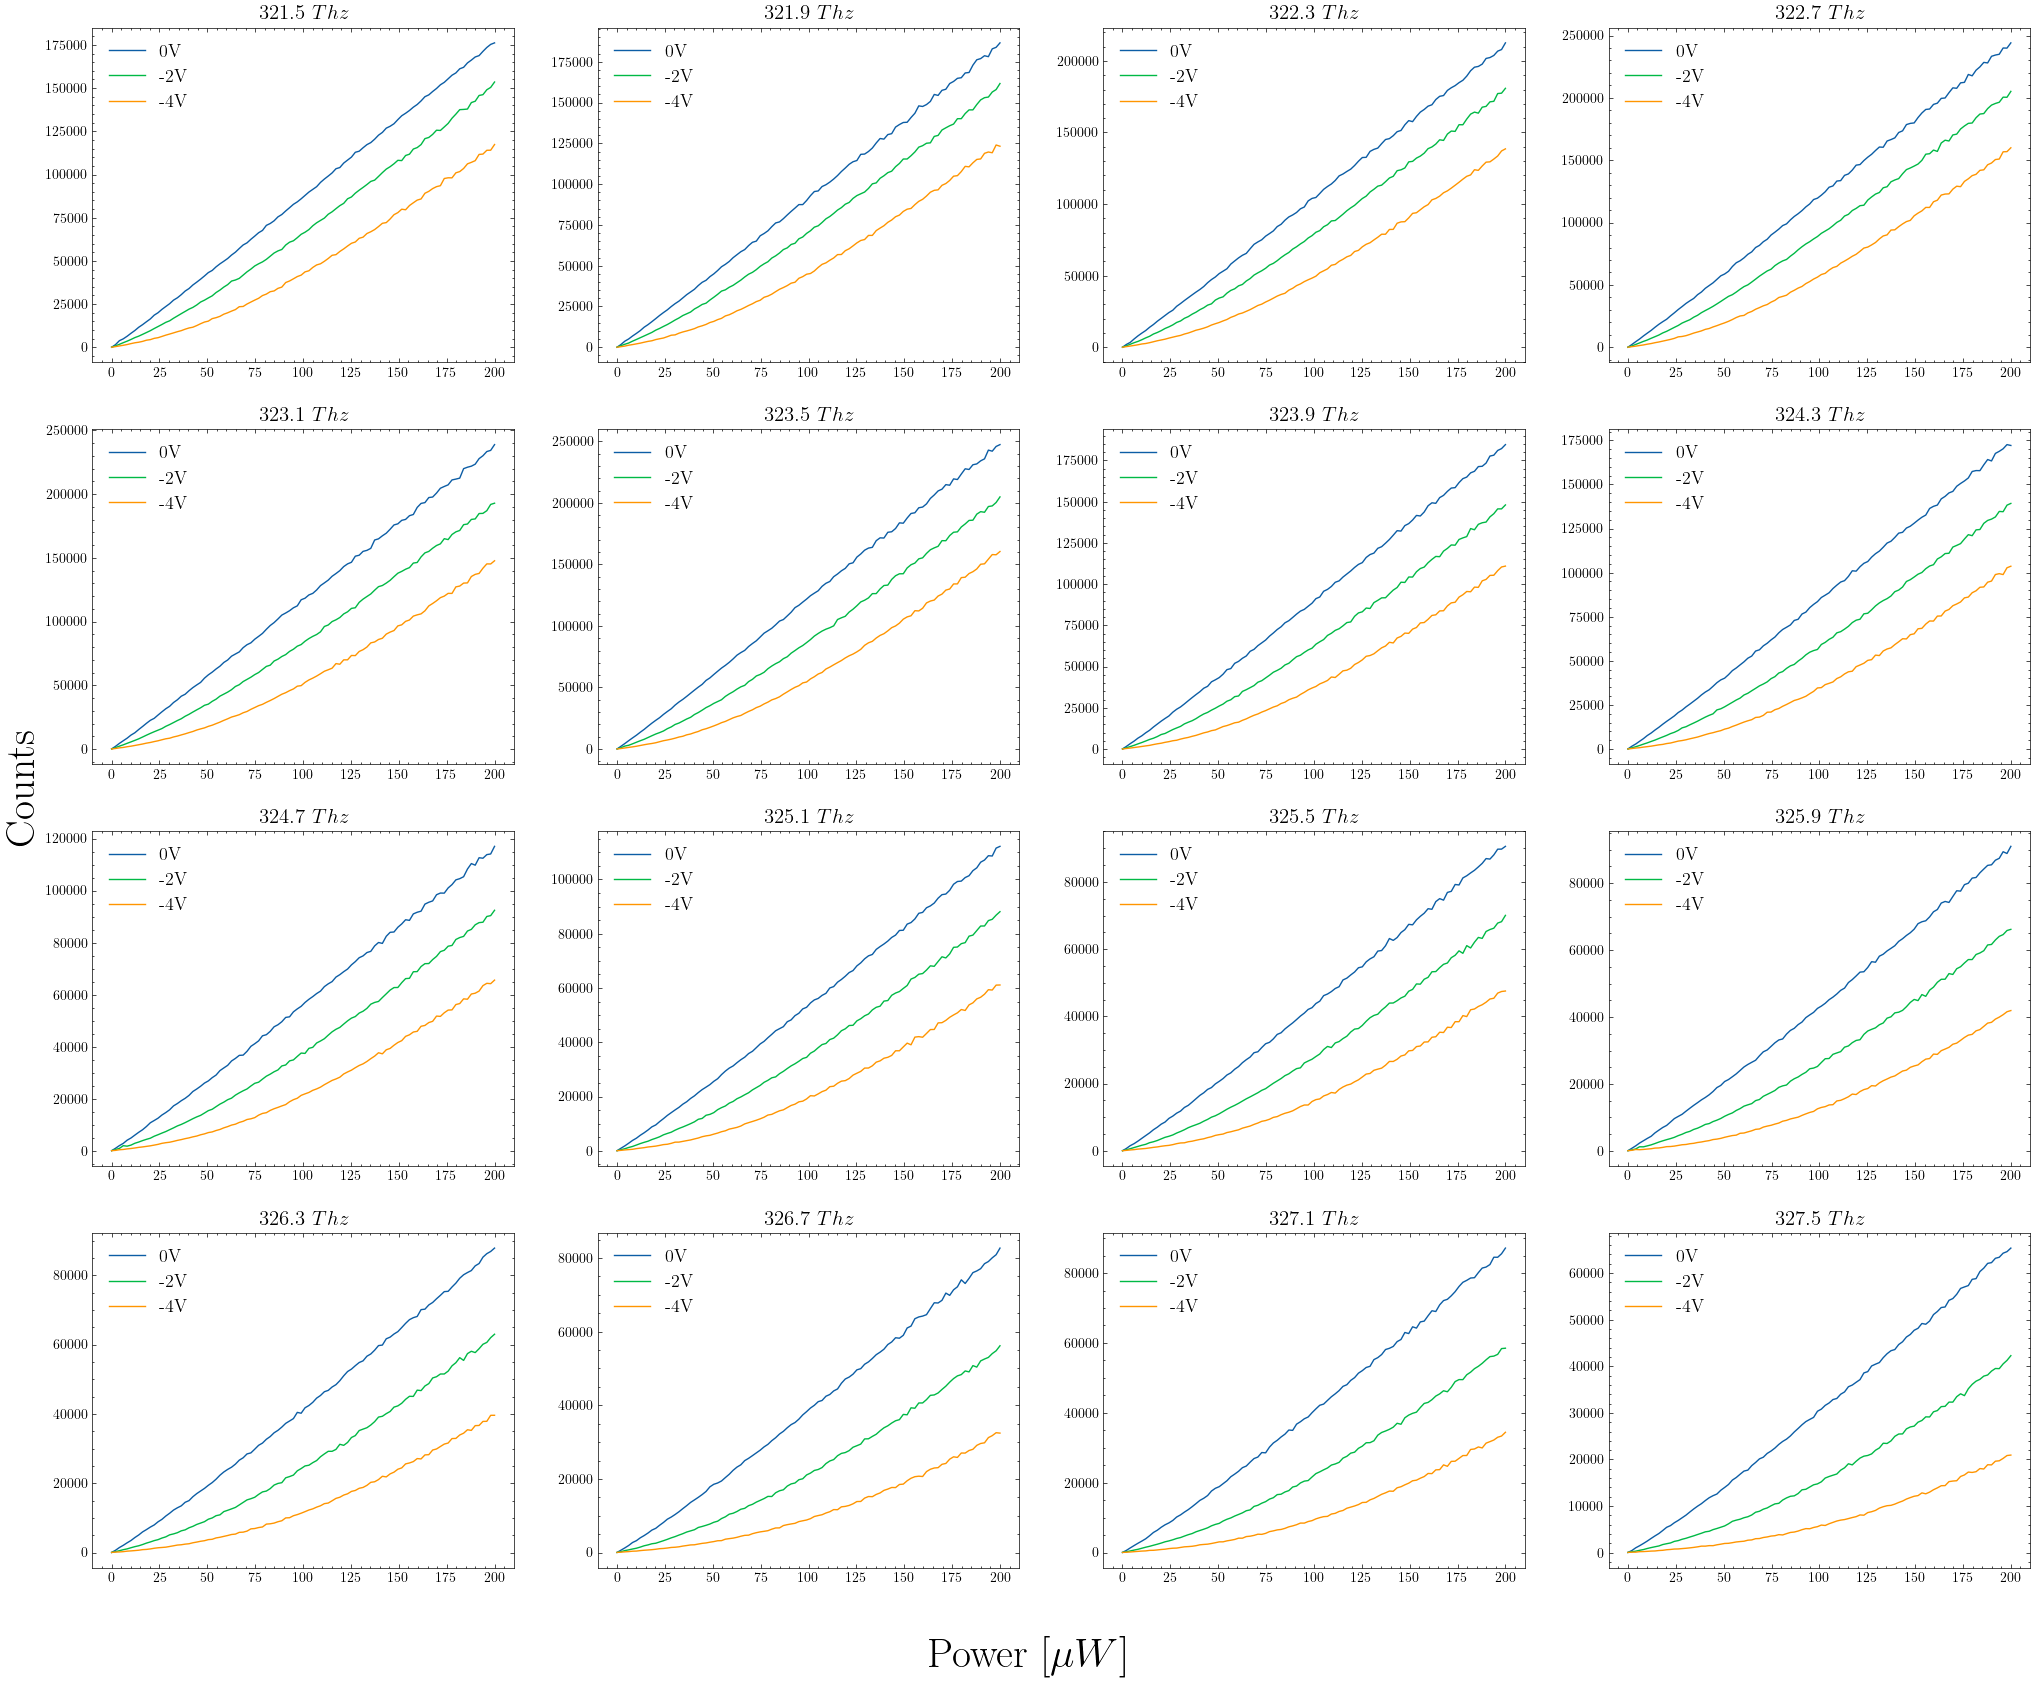

DATA FOR RESISTANCE: 807,000


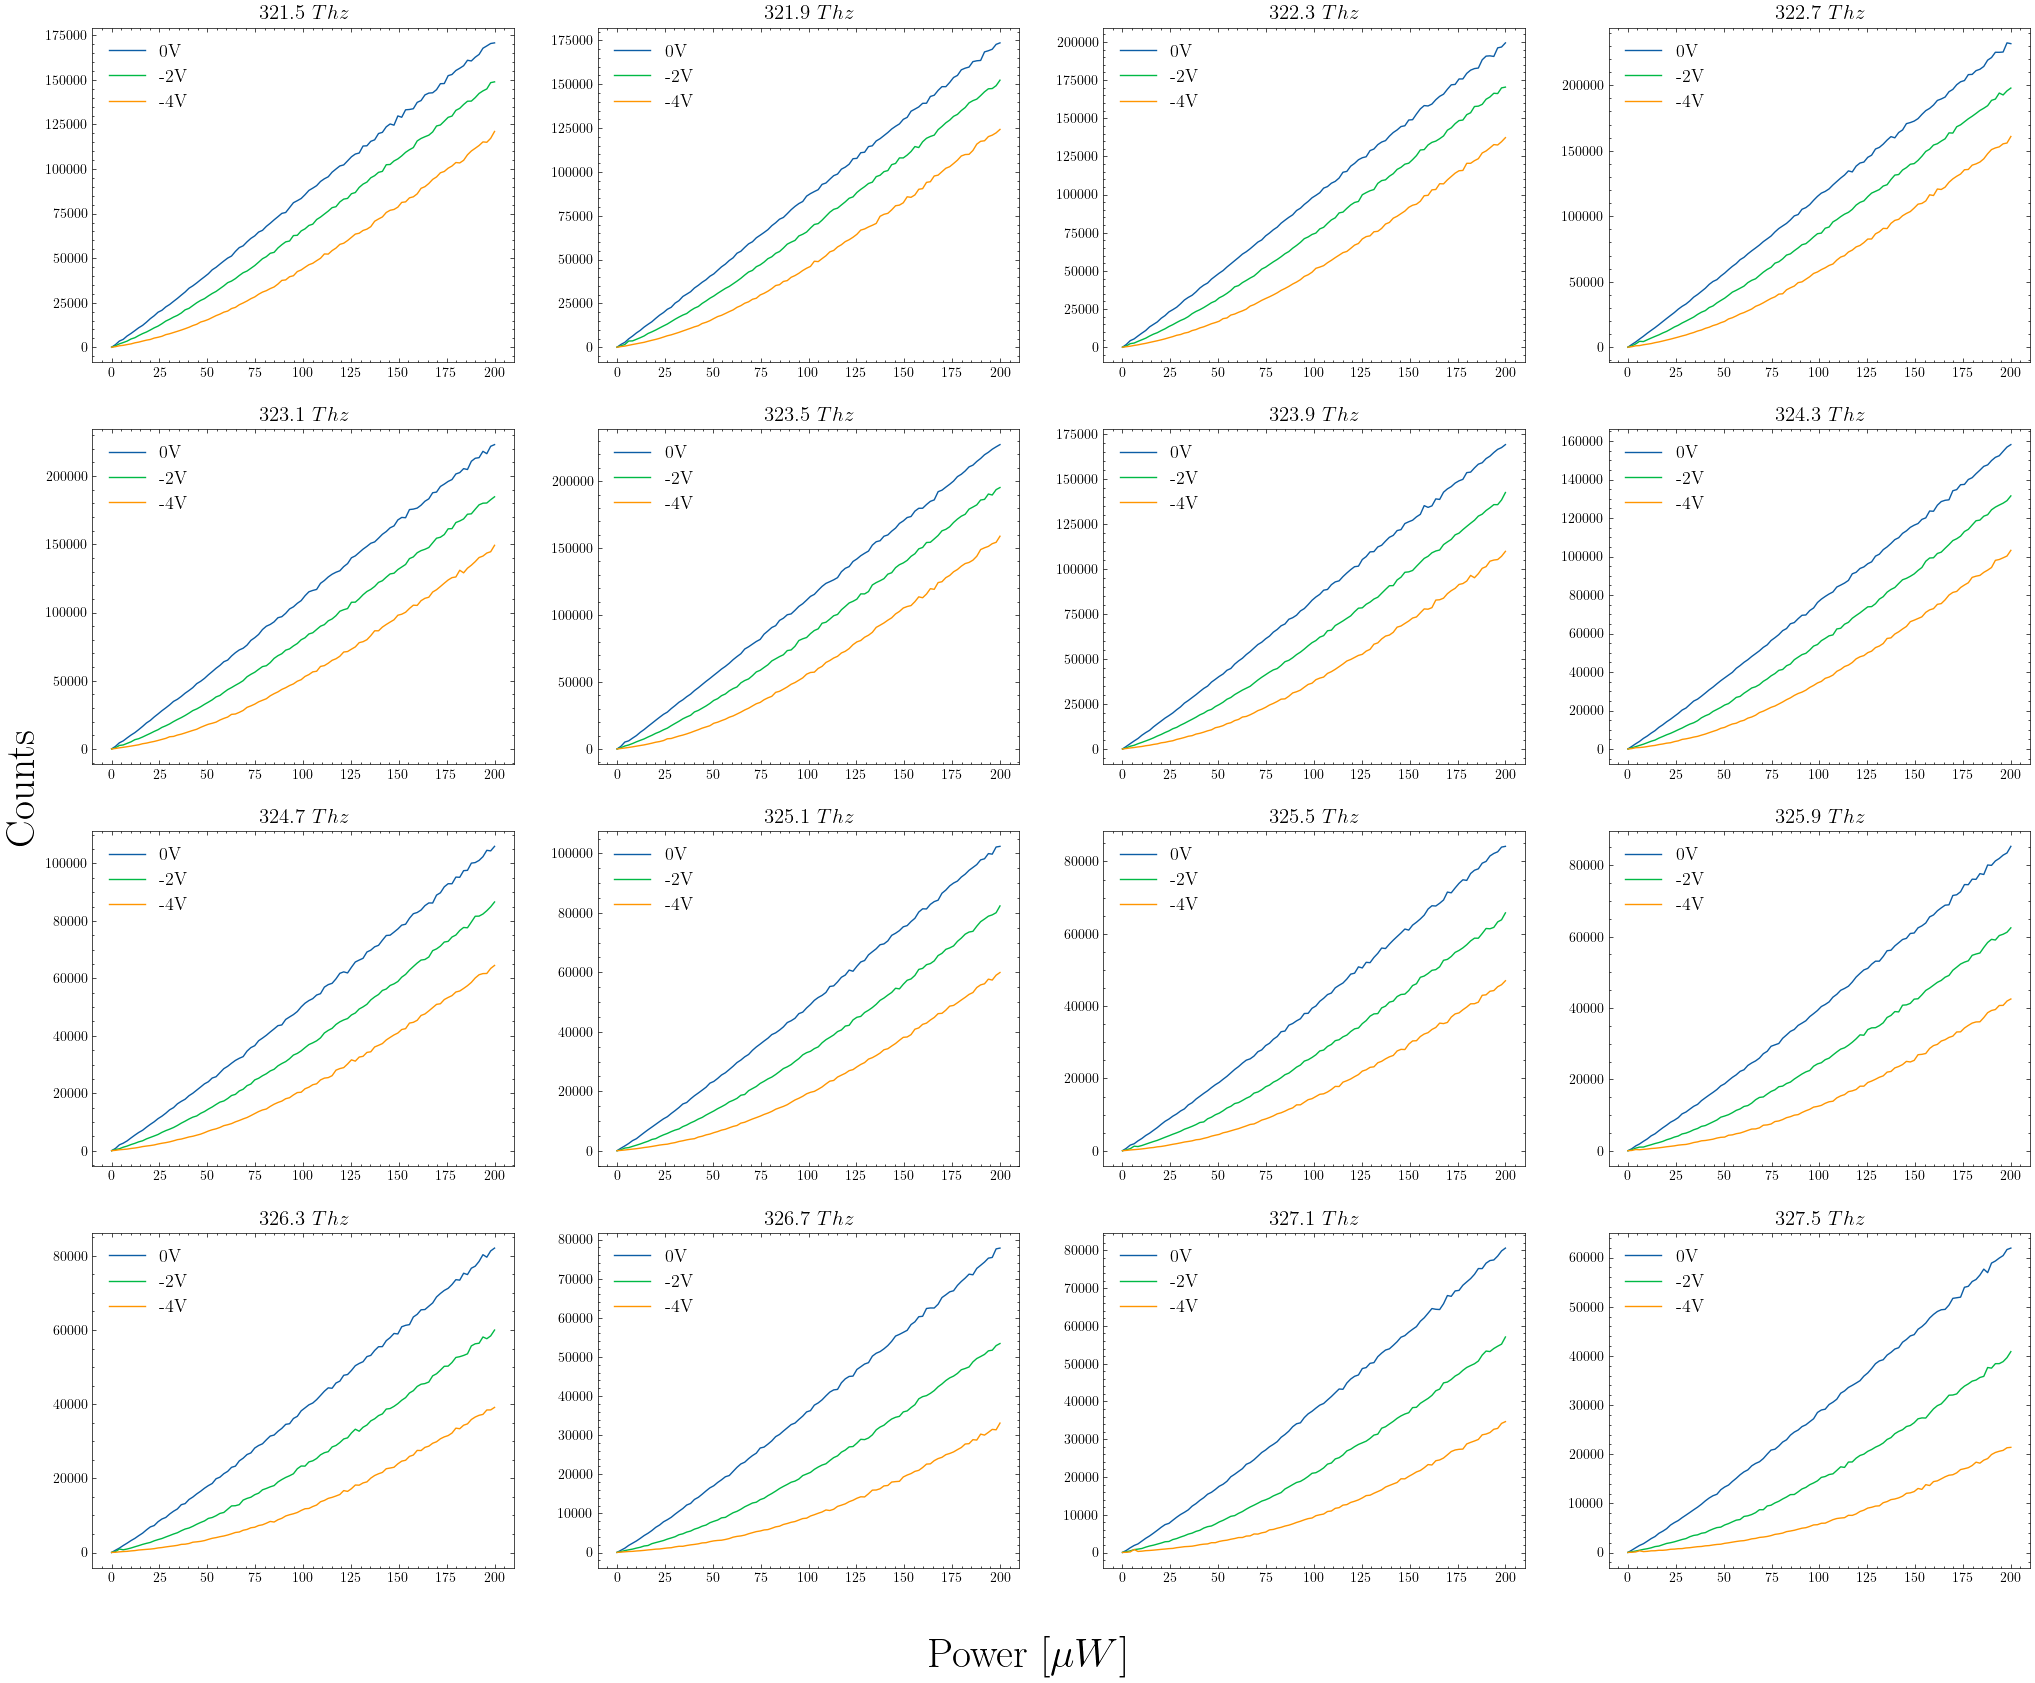

DATA FOR RESISTANCE: 1,000,000


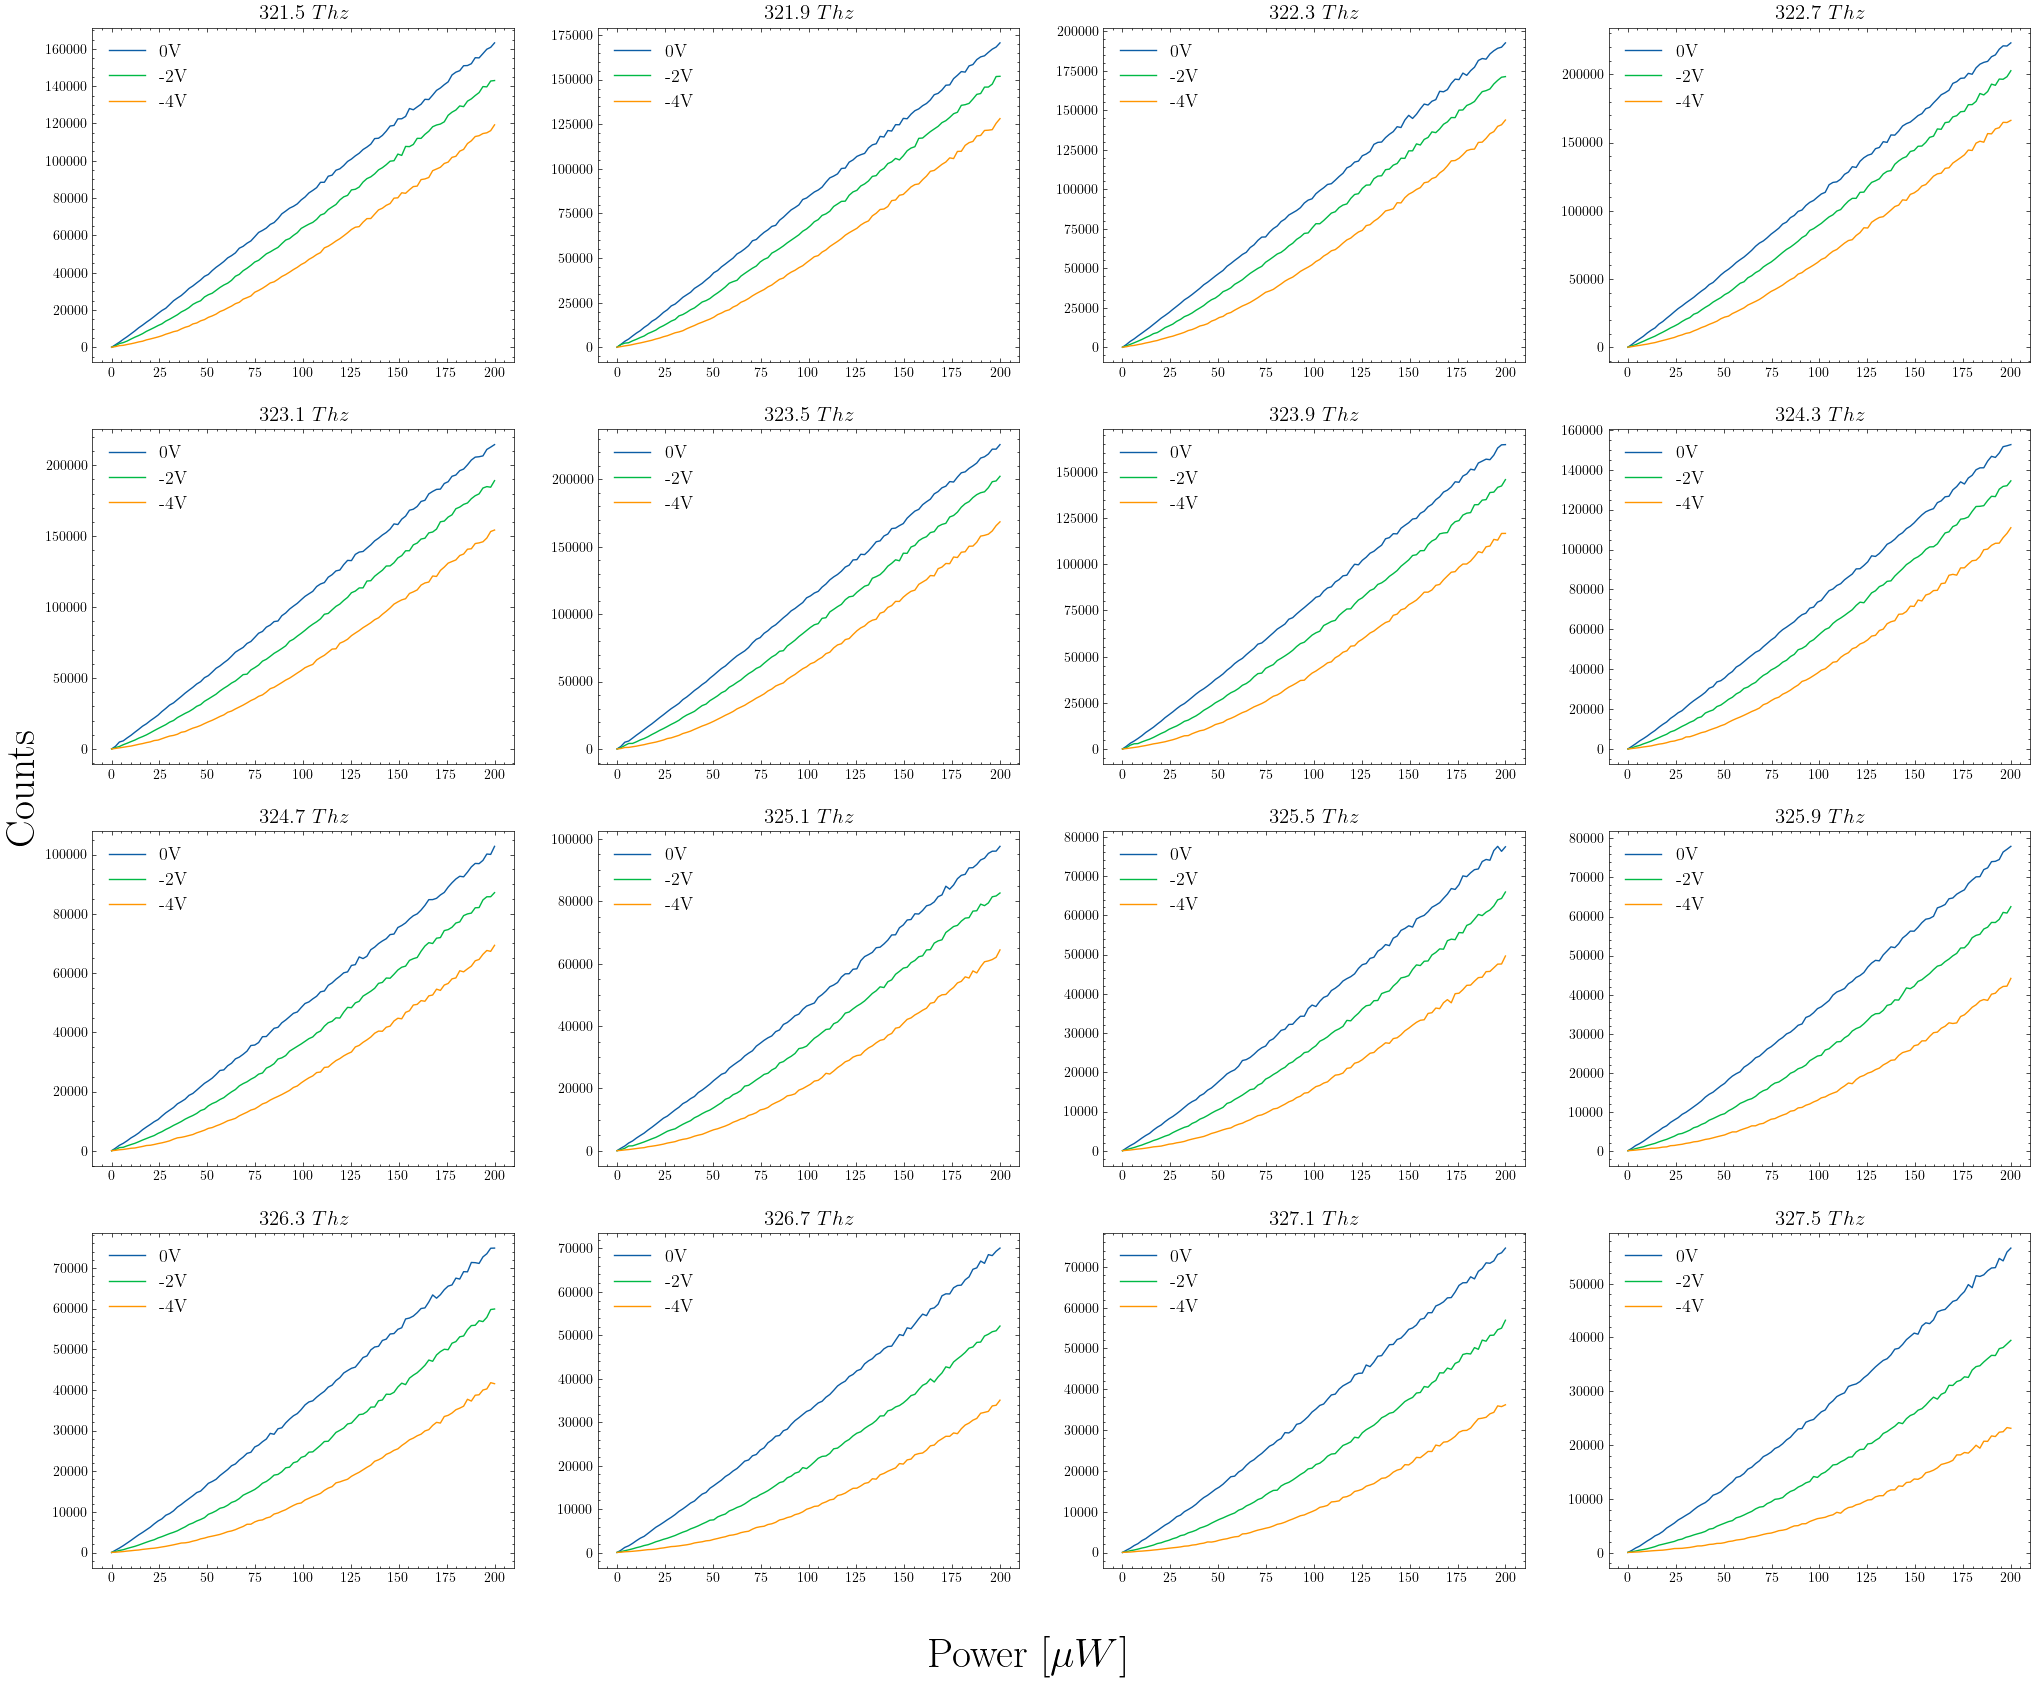

DATA FOR RESISTANCE: 3,012,000


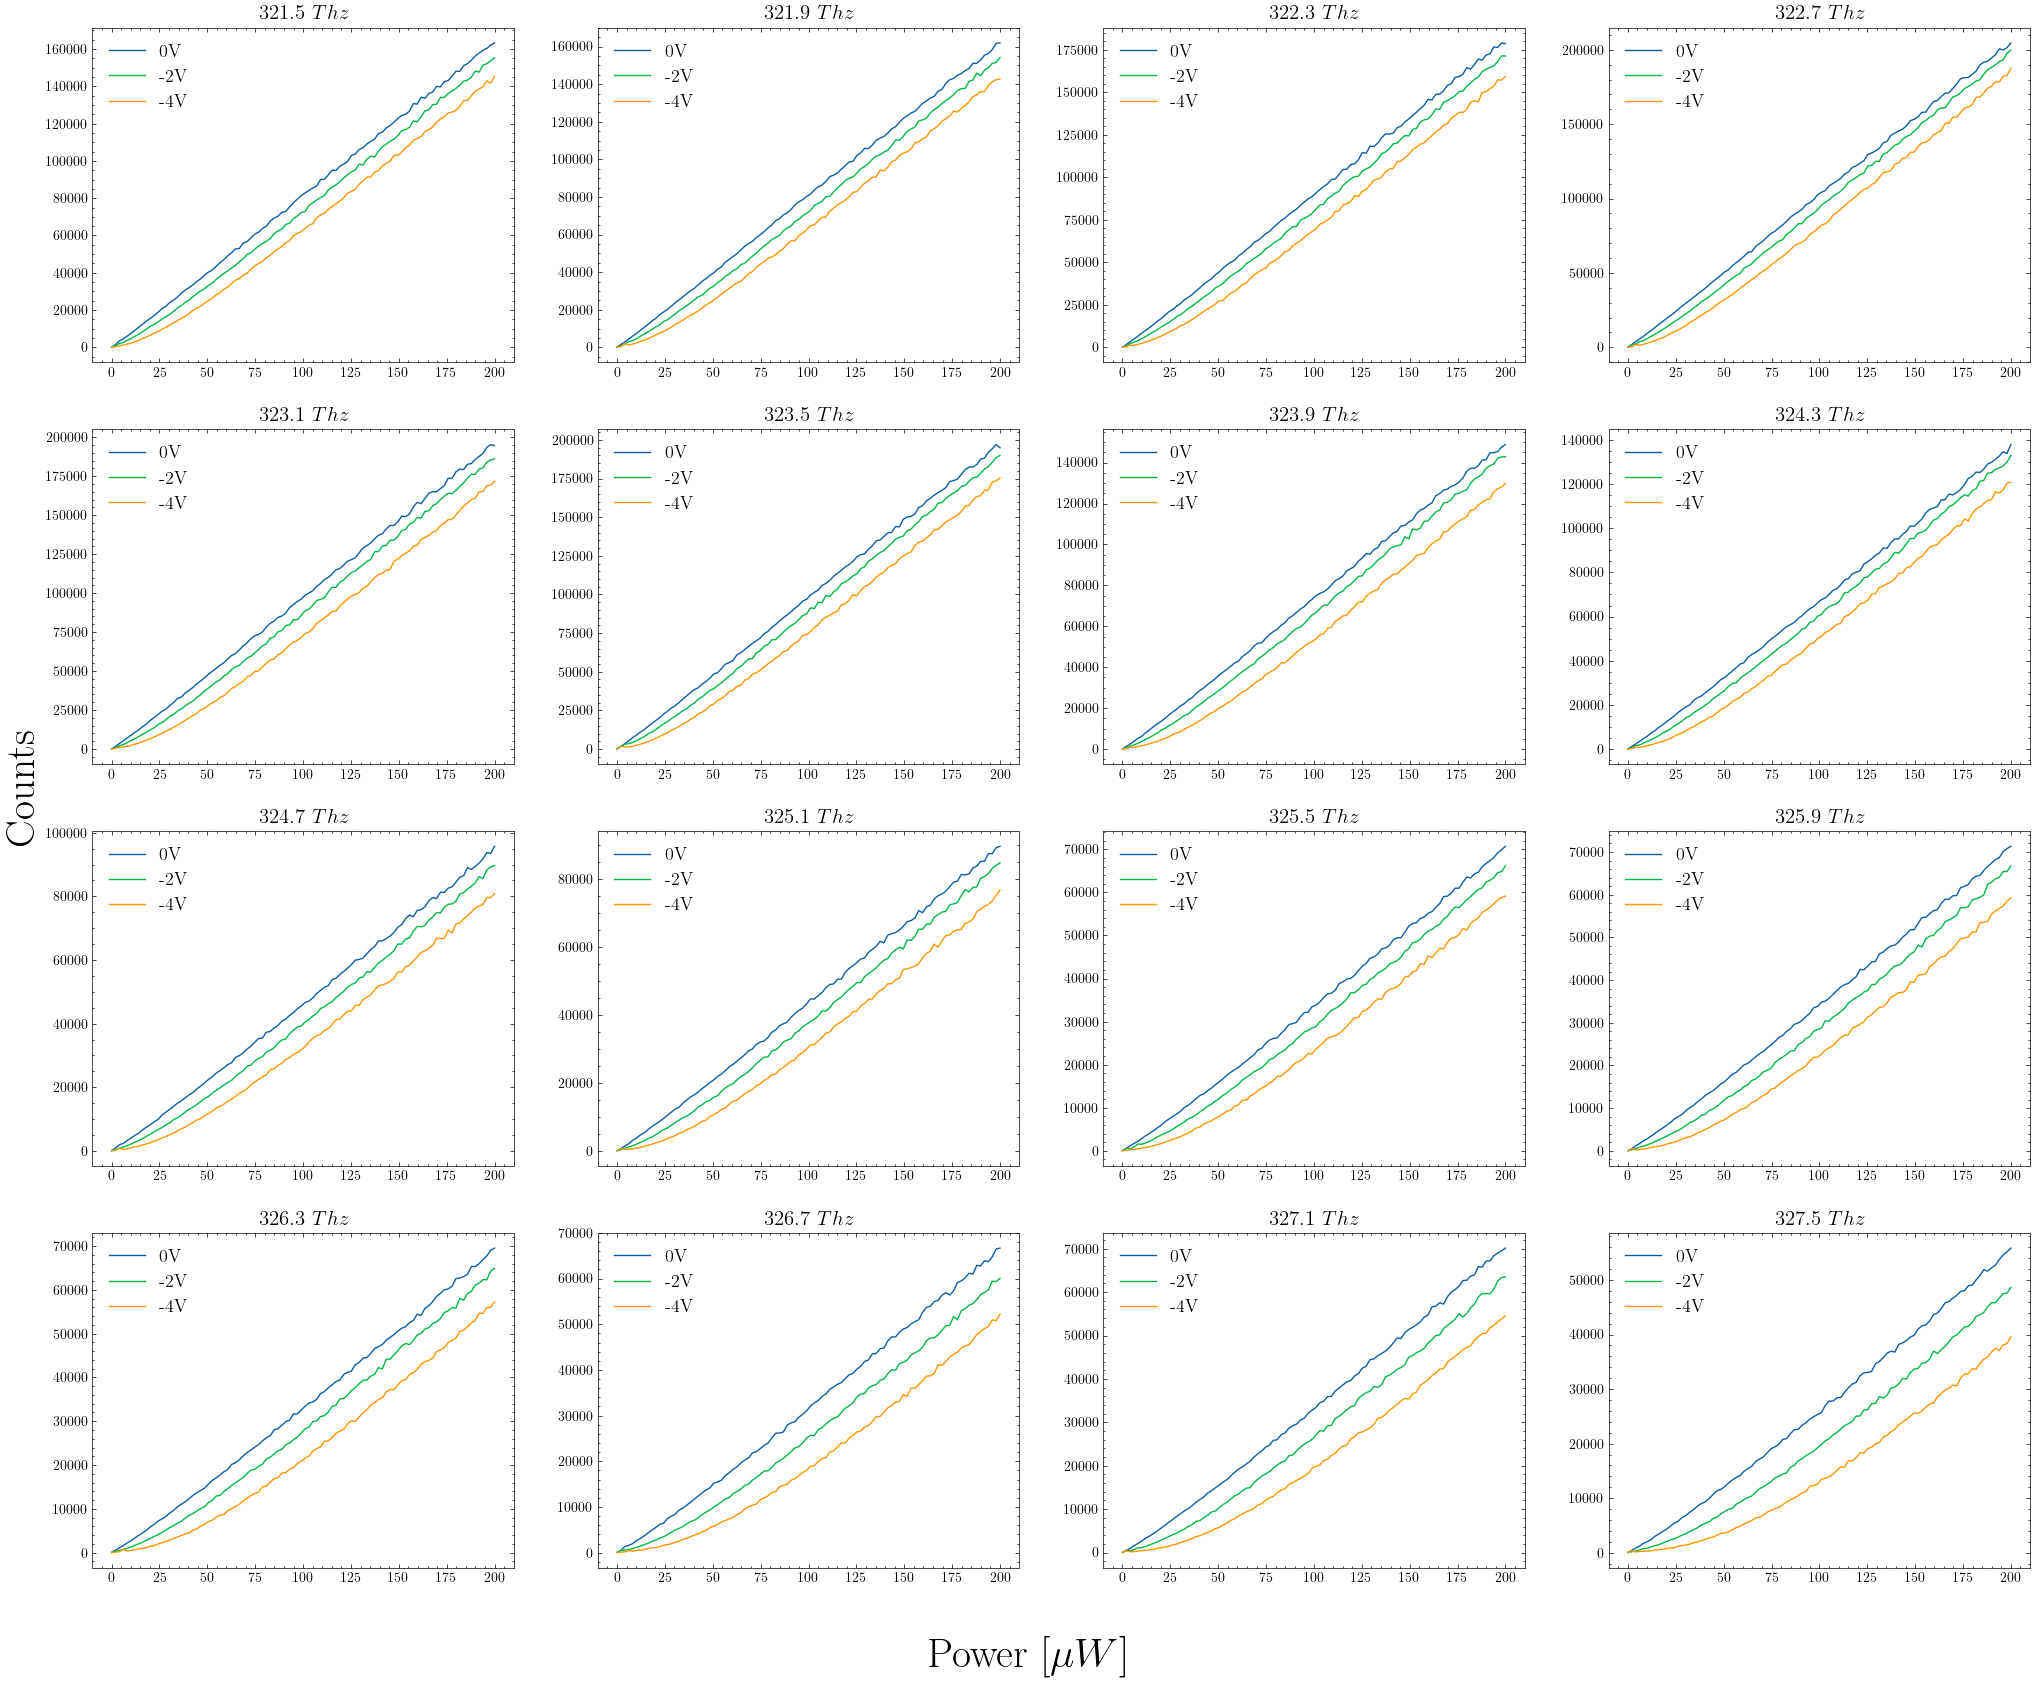

DATA FOR RESISTANCE: 10,000,000


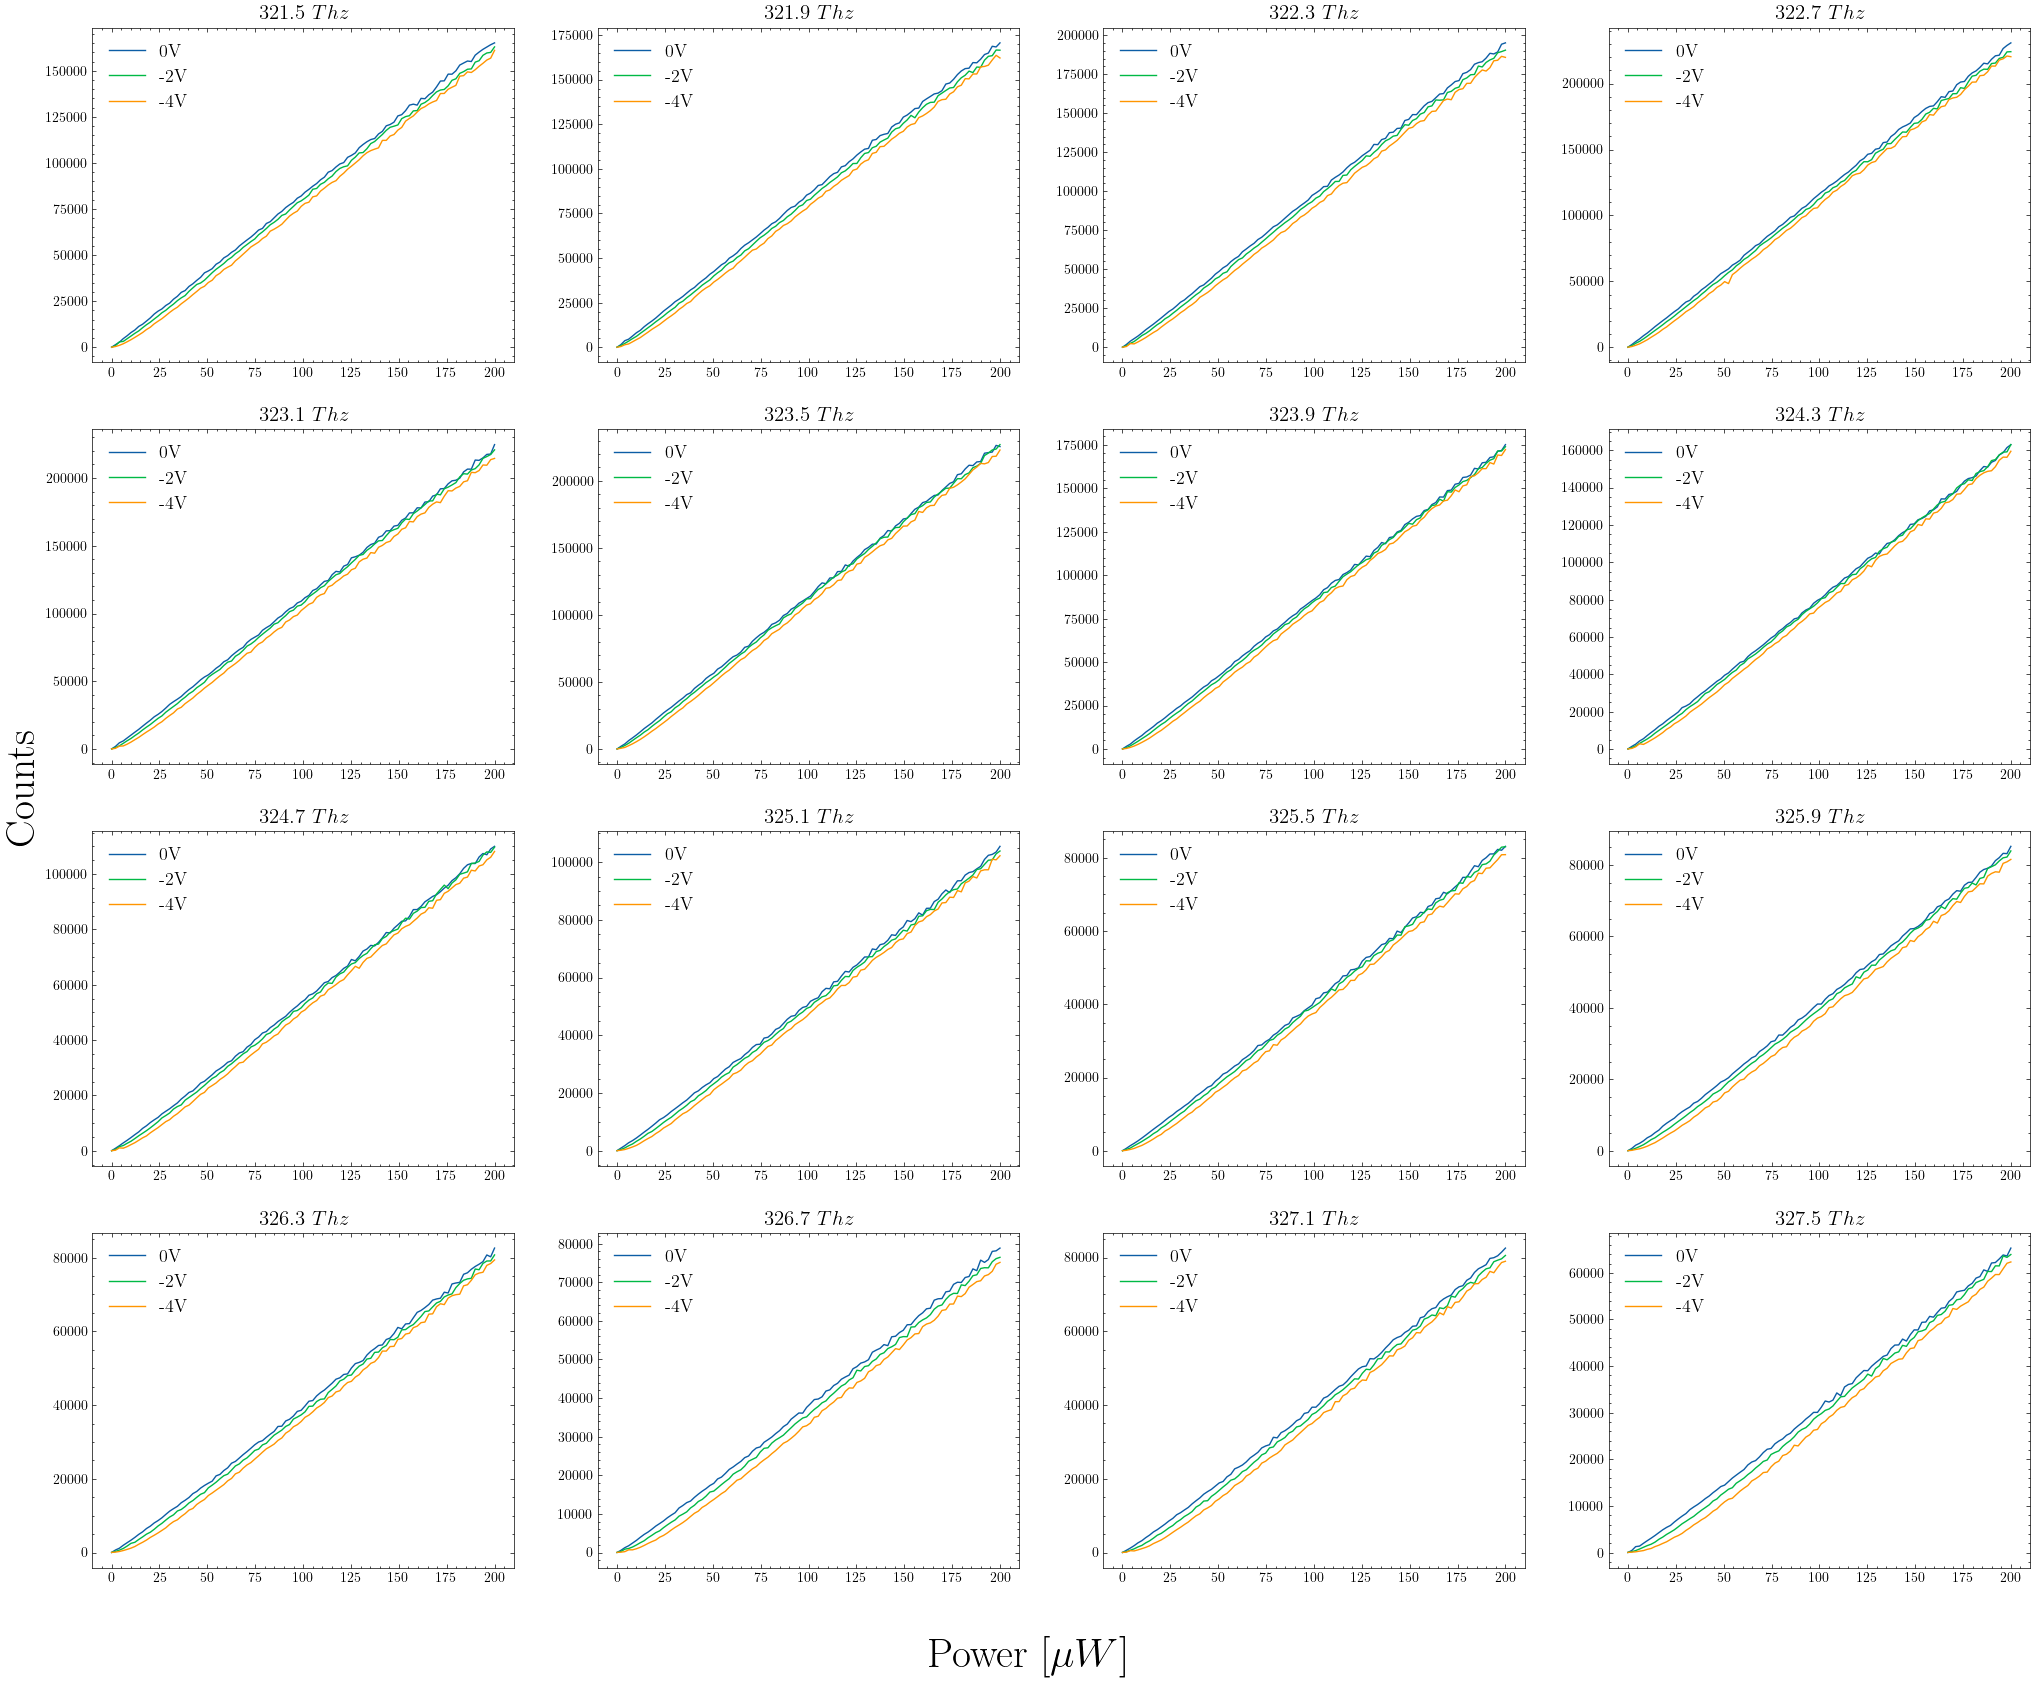

In [8]:
plot_power_counts(data_dict, powerlist, freqlist, voltages, resistances)

DATA FOR RESISTANCE: 0


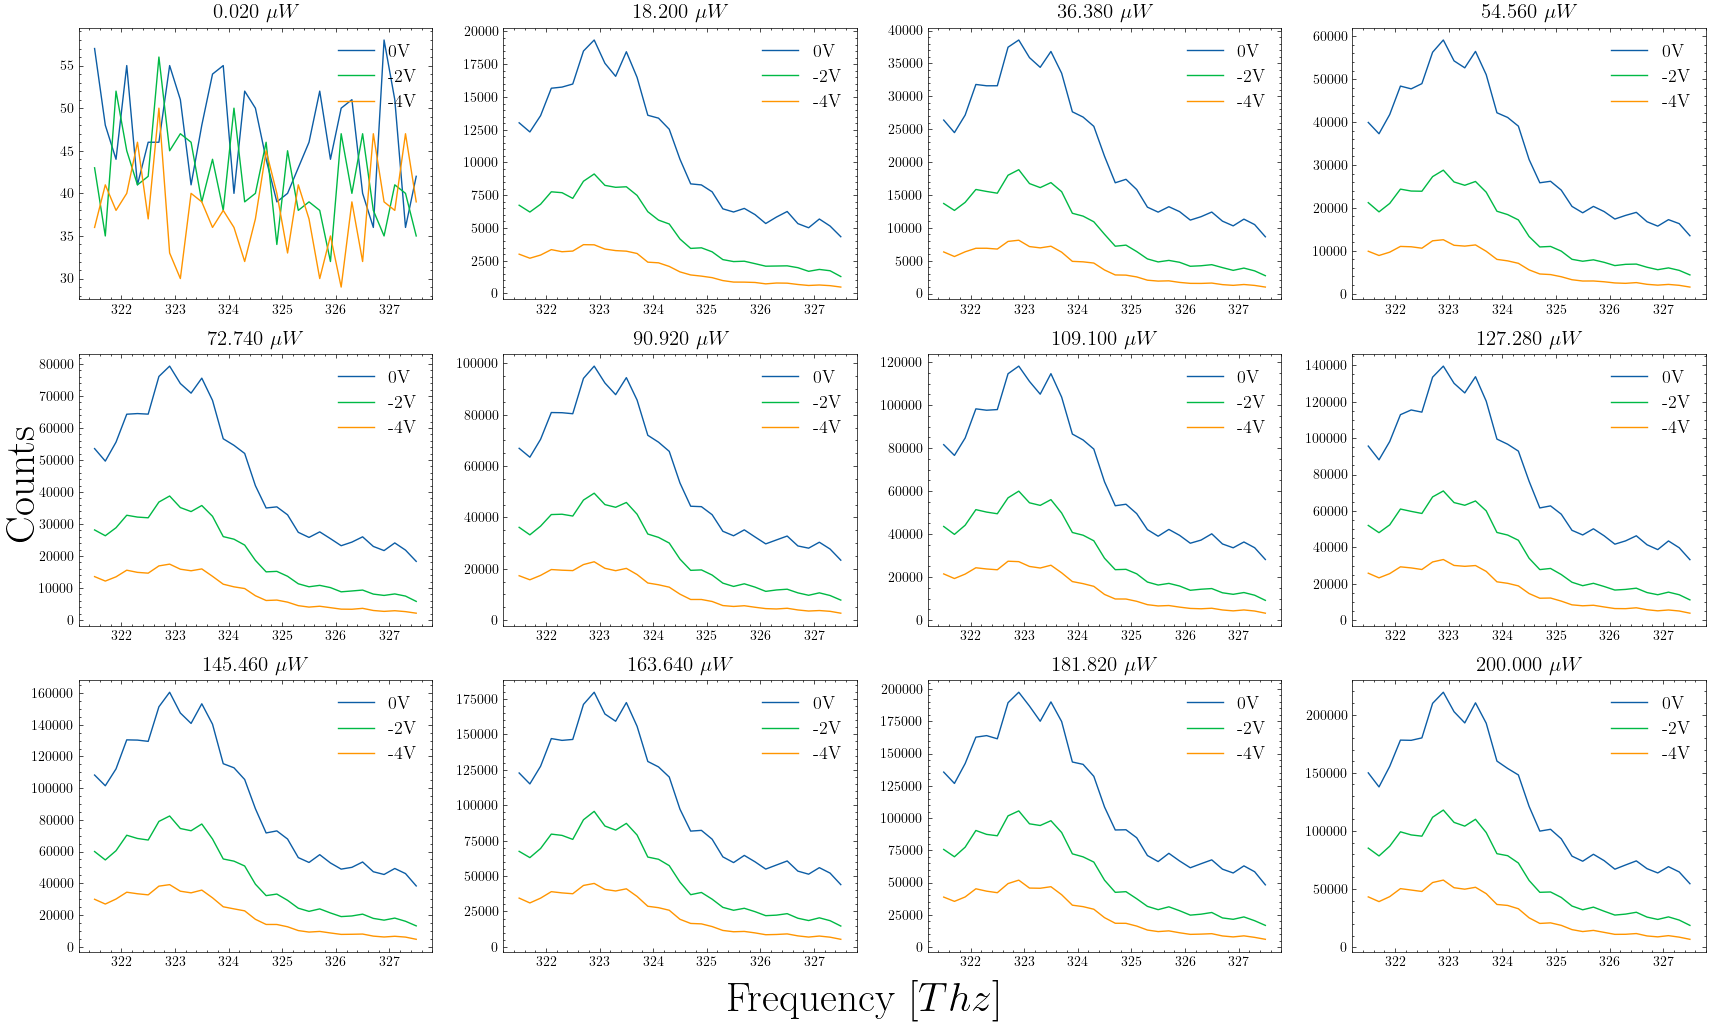

DATA FOR RESISTANCE: 97,500


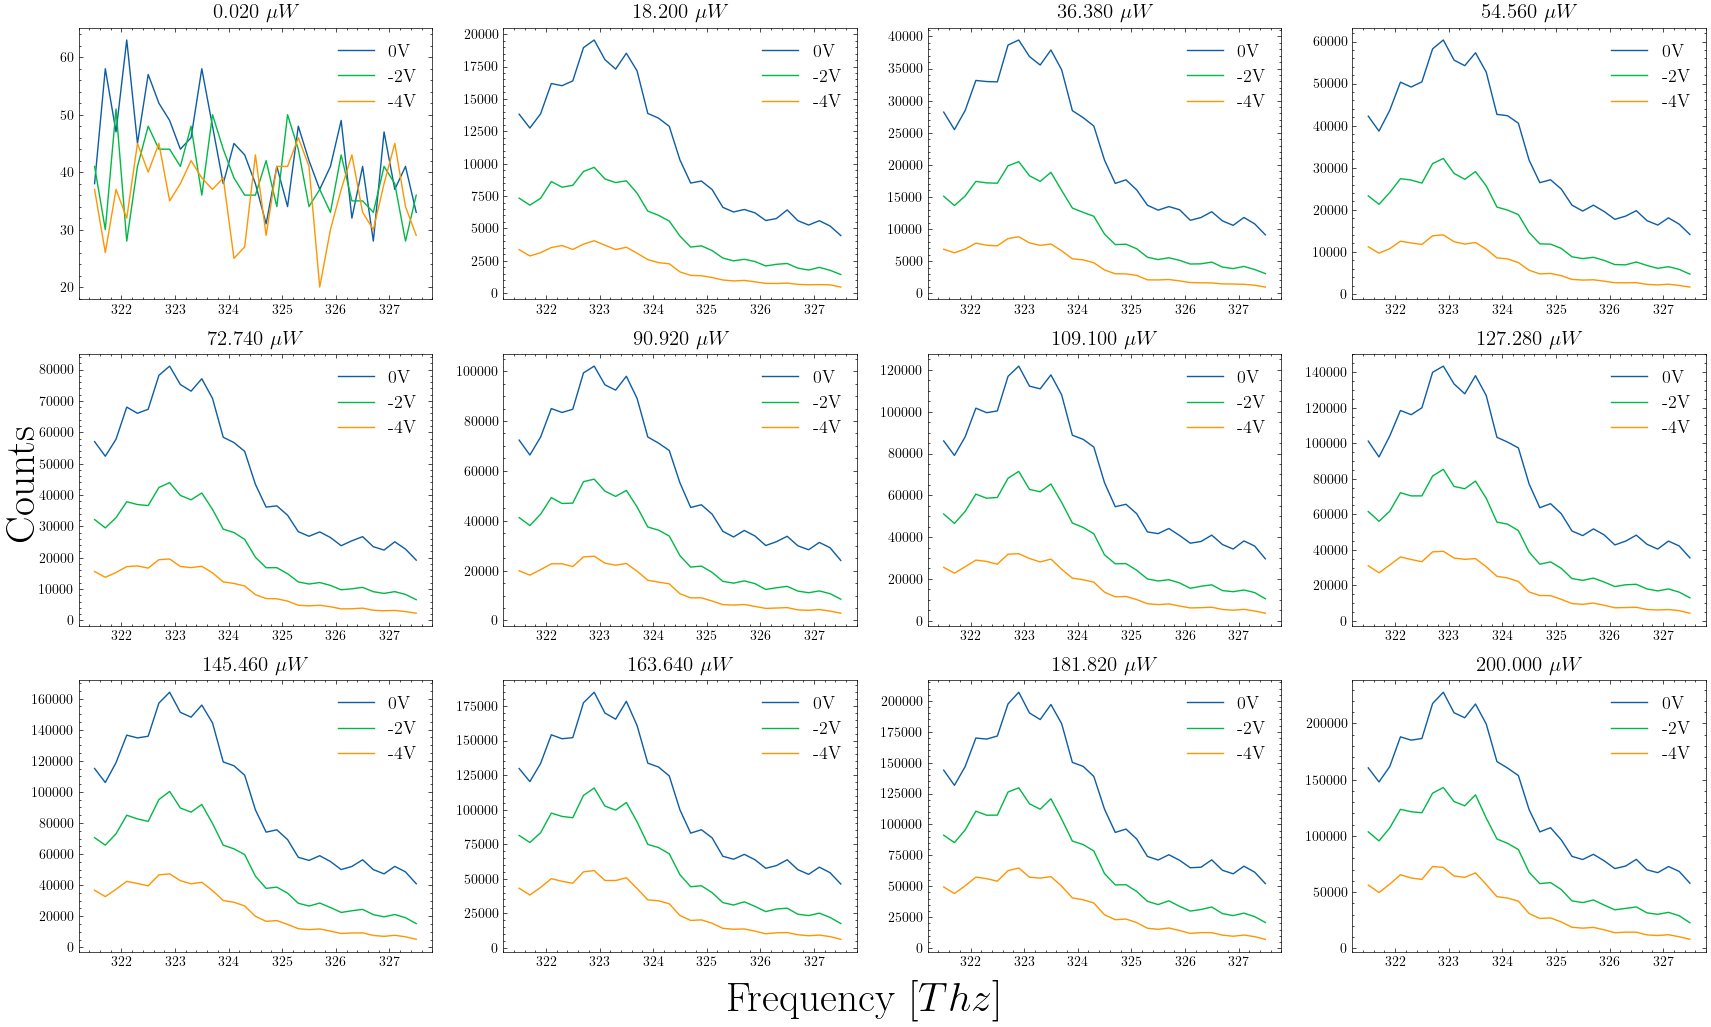

DATA FOR RESISTANCE: 325,300


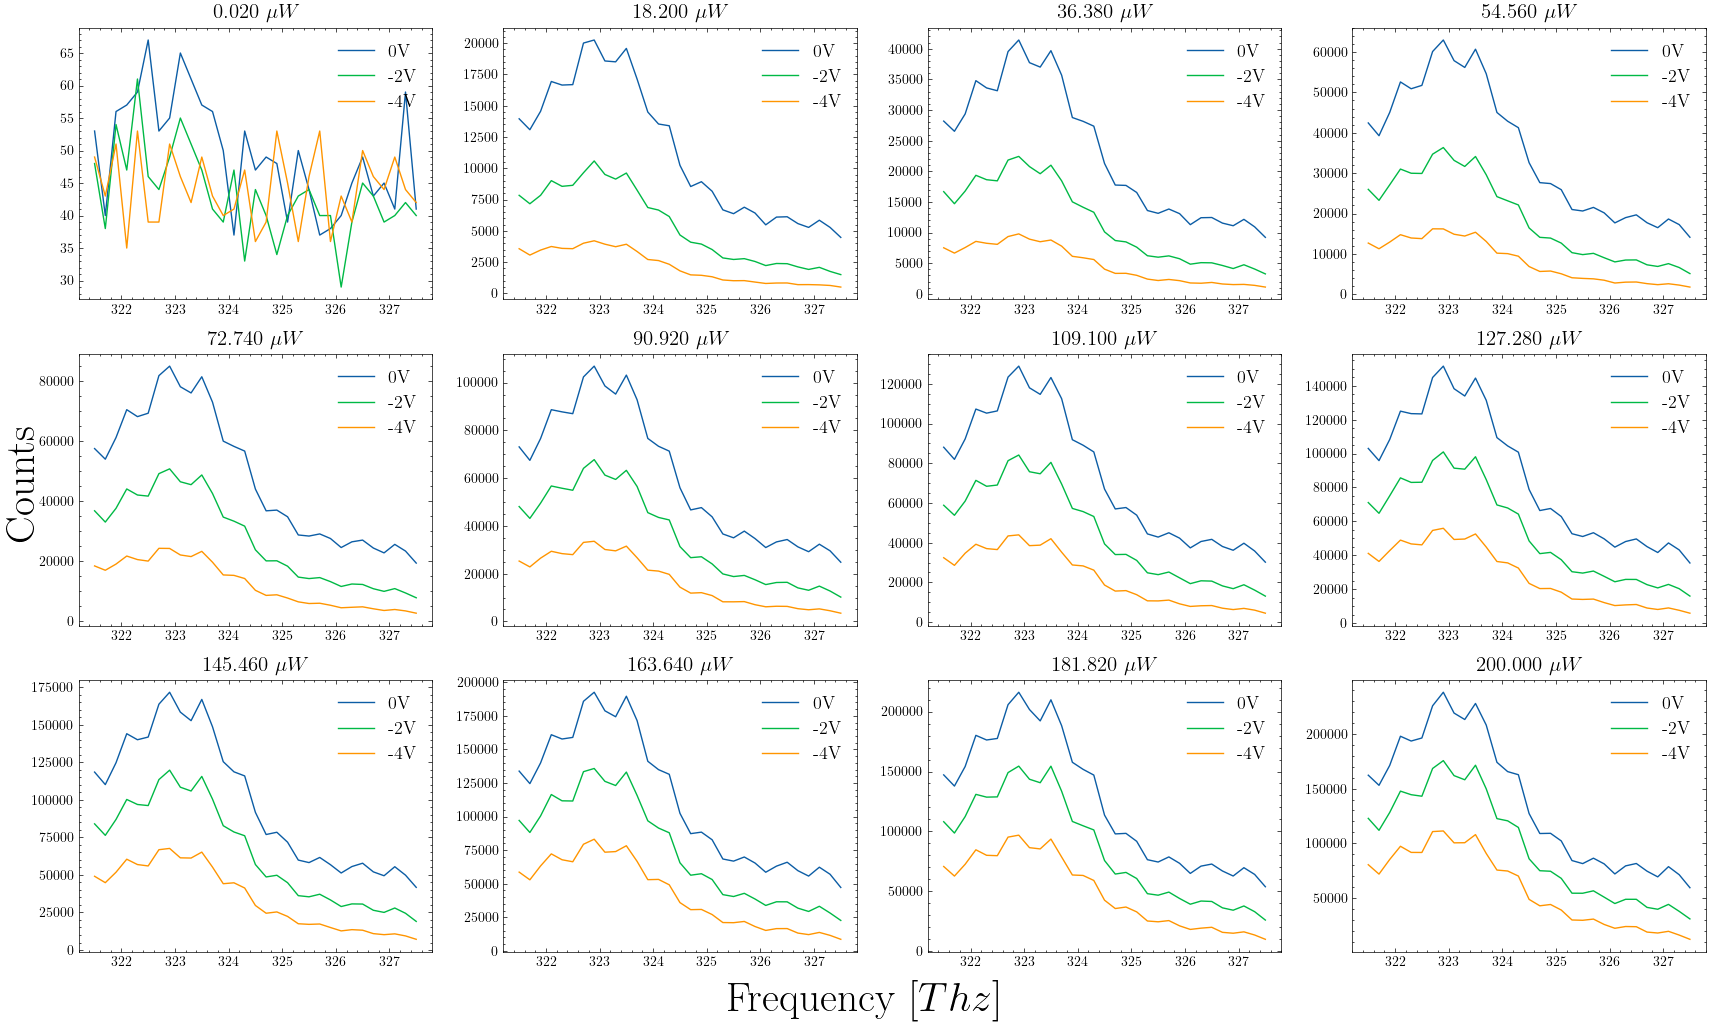

DATA FOR RESISTANCE: 552,000


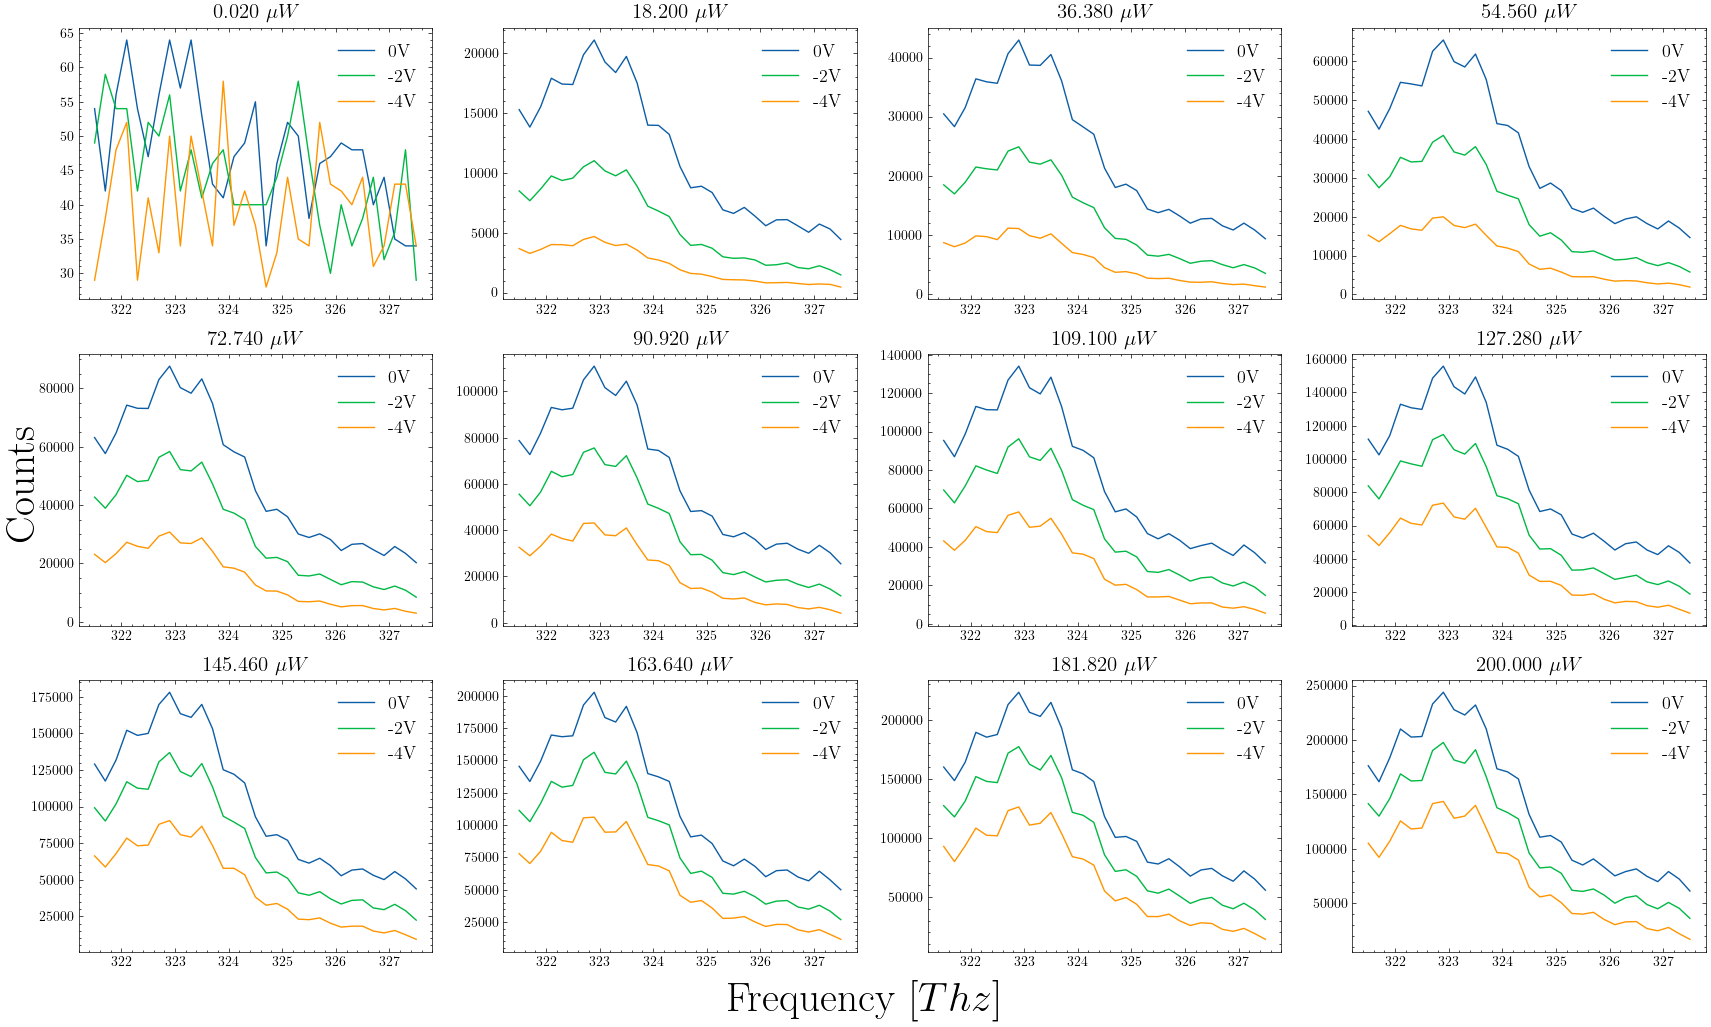

DATA FOR RESISTANCE: 677,000


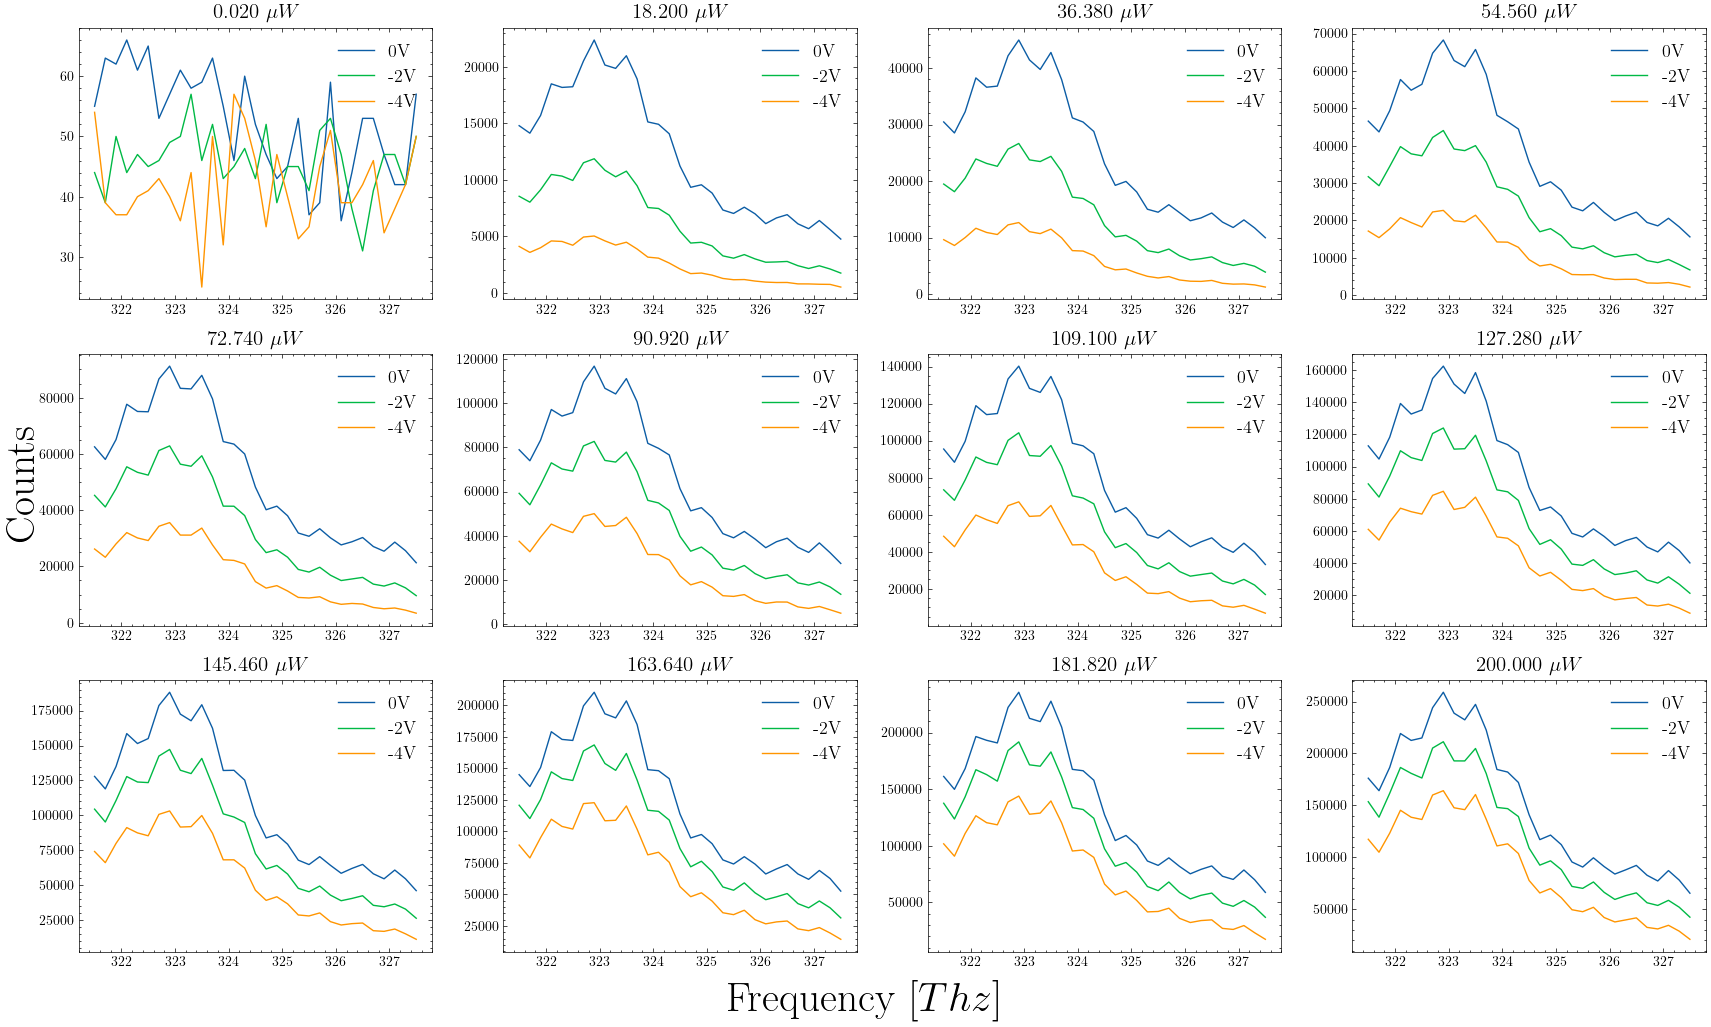

DATA FOR RESISTANCE: 807,000


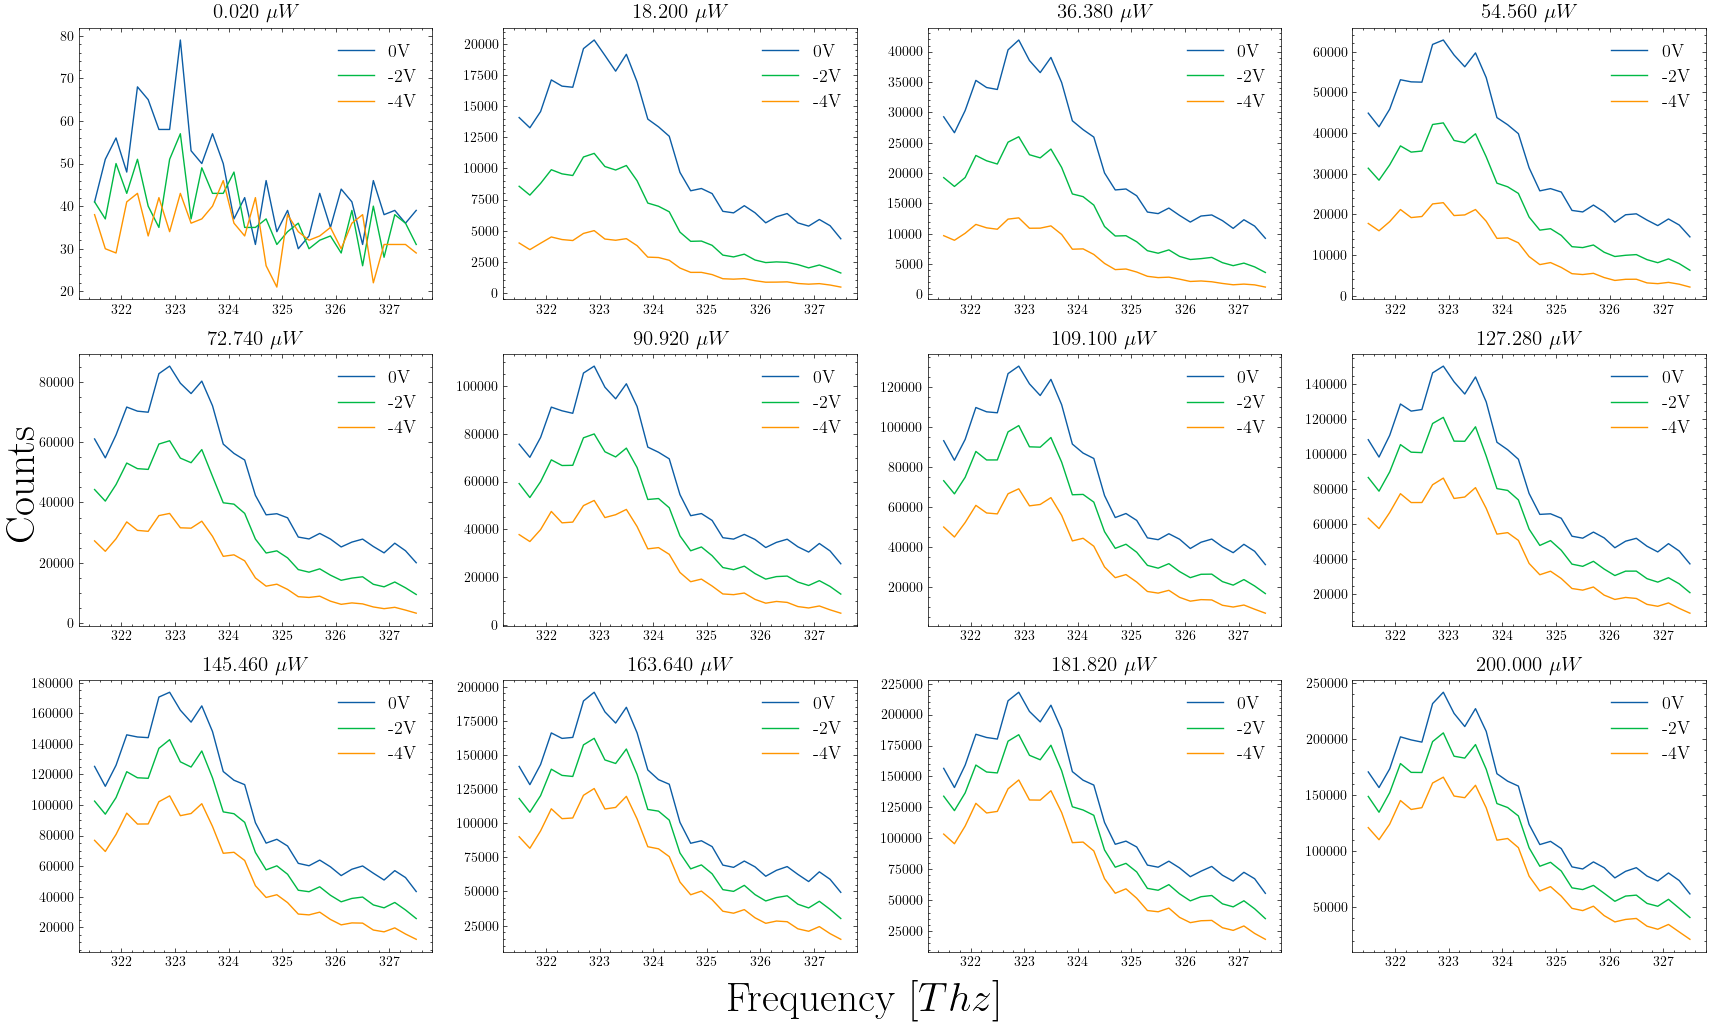

DATA FOR RESISTANCE: 1,000,000


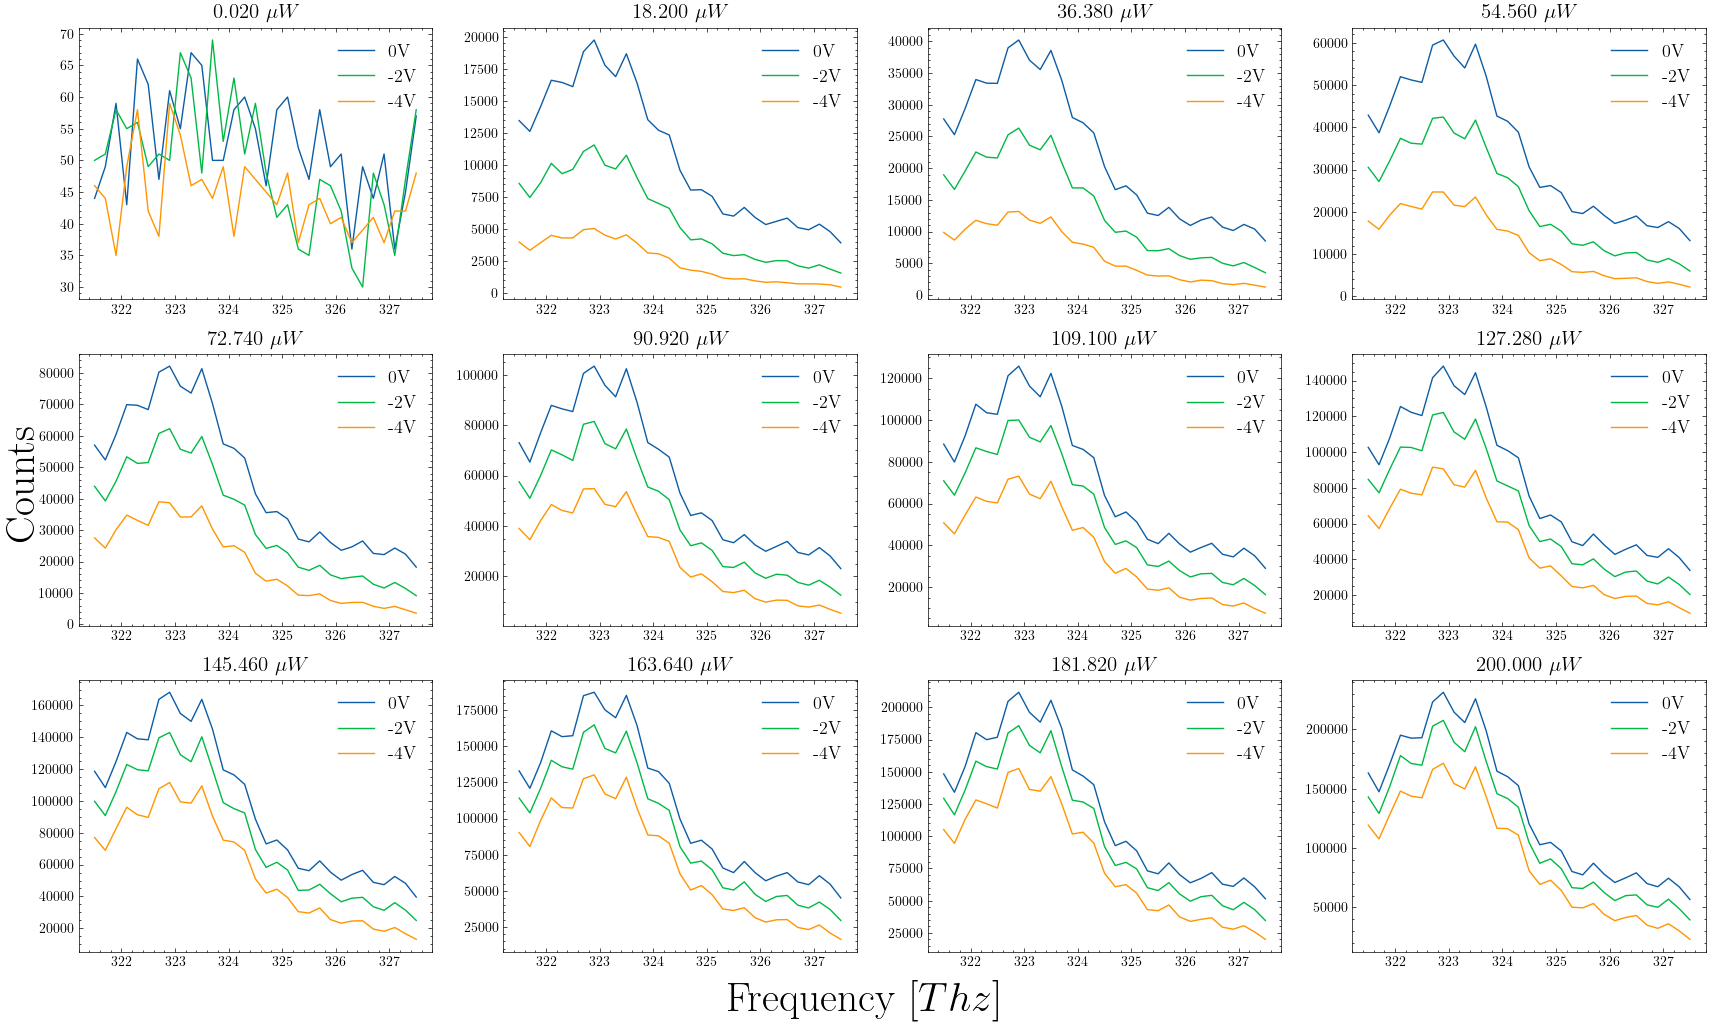

DATA FOR RESISTANCE: 3,012,000


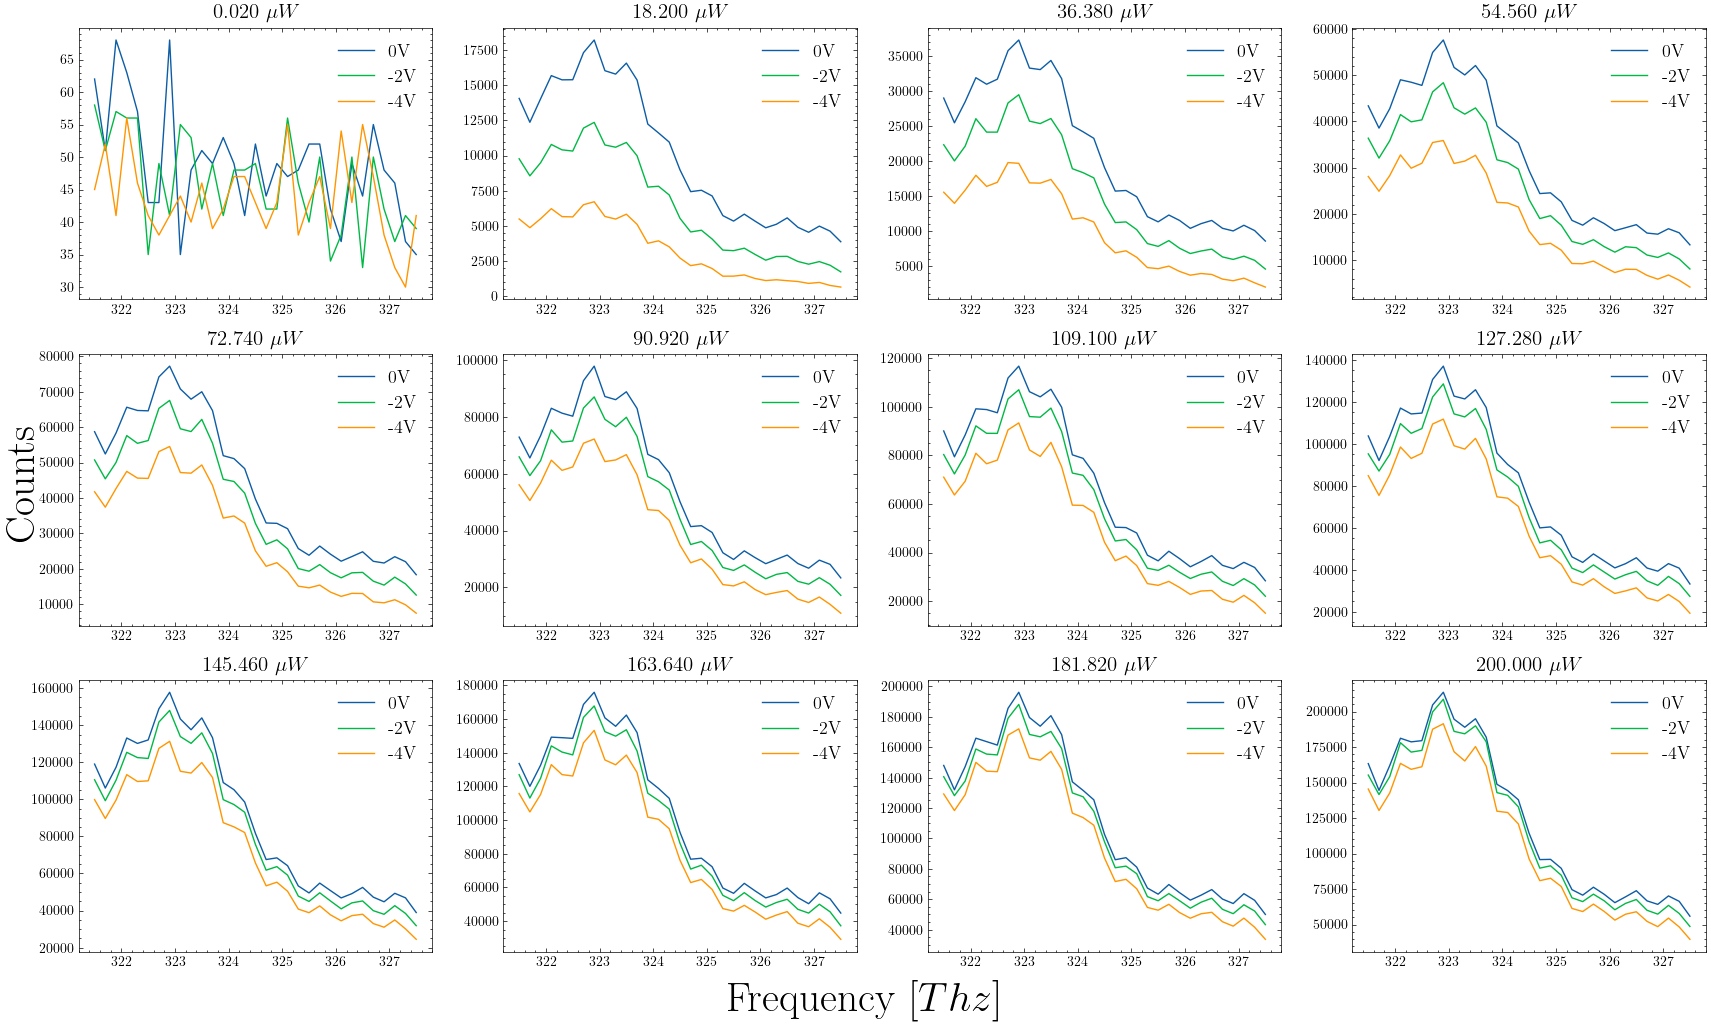

DATA FOR RESISTANCE: 10,000,000


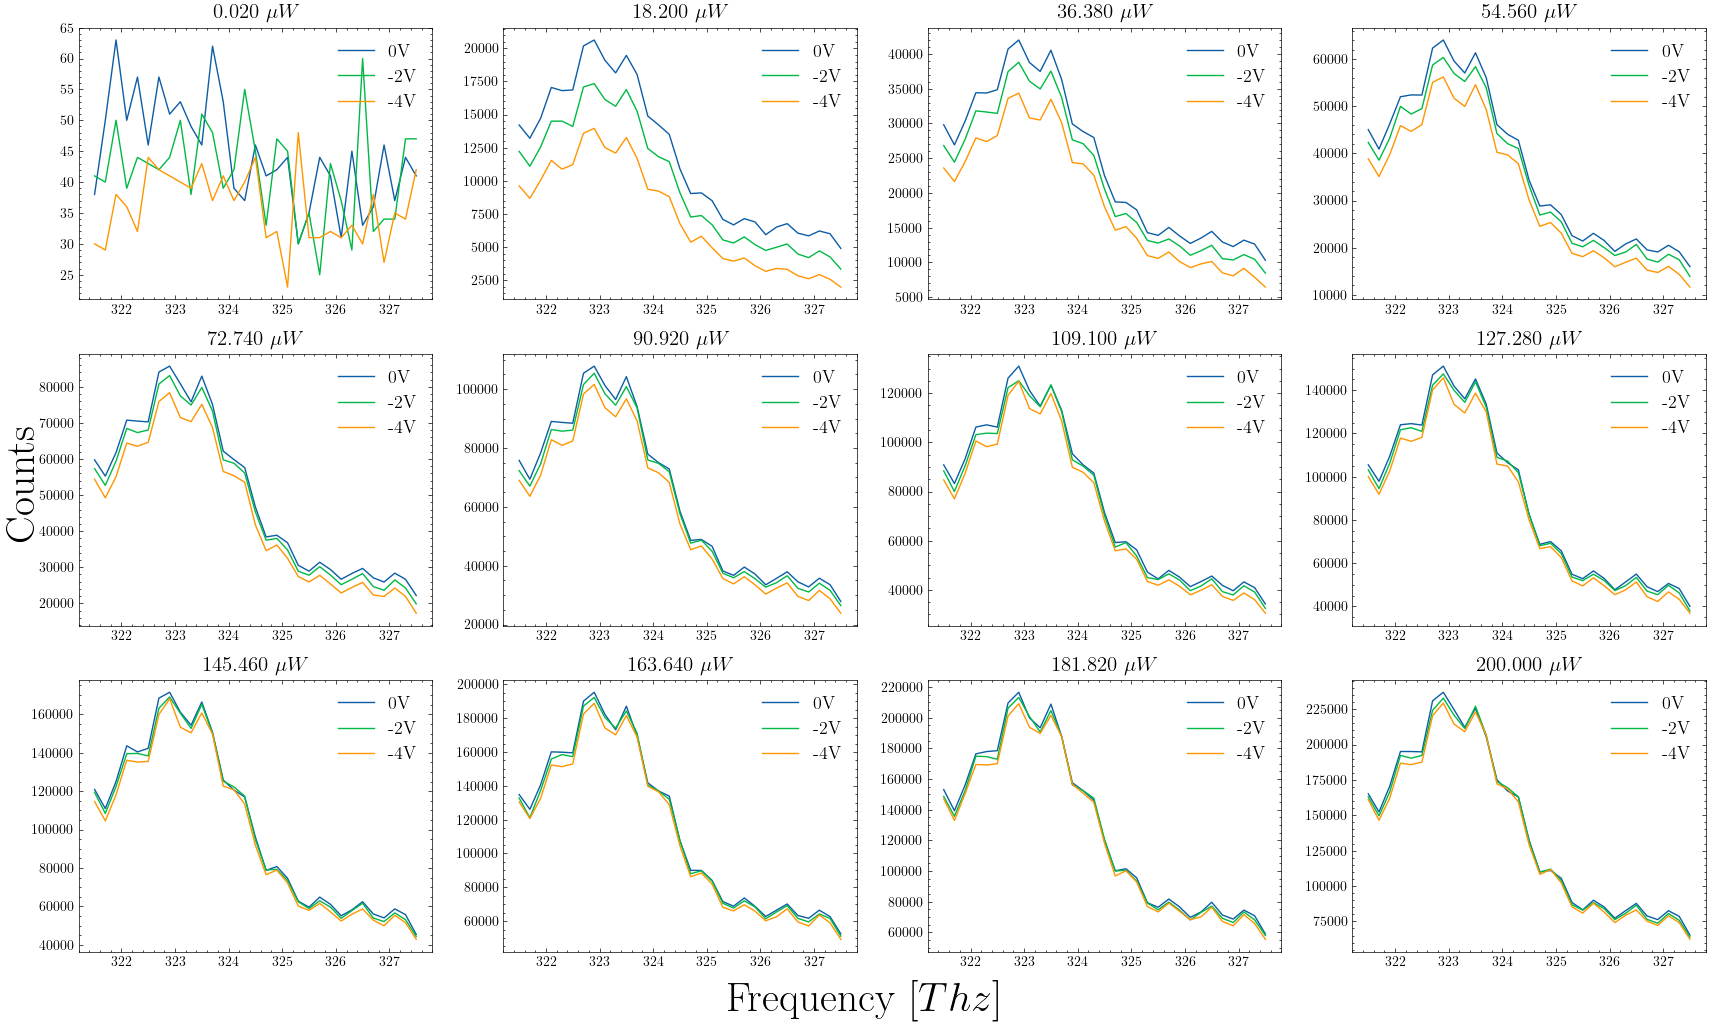

In [9]:
plot_frequency_counts(data_dict, powerlist, freqlist, voltages, resistances)

In [7]:
data_dict[0][-4].keys()

dict_keys(['m_freq', 'counts', 'current'])

In [8]:
def calculate_nl_coeff(fit_input: FitInput, fit_result: FitResult) -> np.ndarray:
    linspace = np.linspace(np.min(powerlist), np.max(powerlist), 1000)
    y_fit = fit_input.fit_func(linspace, *fit_result.parameters)
    deriv = np.gradient(y_fit, linspace, edge_order=2)
    deriv2 = np.gradient(deriv, linspace, edge_order=2)

    max_idx = np.argmax(deriv2)

    if max_idx == 0:
        nl_coeff = 0
    else:
        nl_coeff = deriv2[max_idx]

    nl_pow = linspace[max_idx]
    return nl_coeff, nl_pow

def pf_power_counts_fit(data_dict: dict, resistance: int, voltages: np.ndarray, powers: np.ndarray, freq_indices: list[int]) -> FitResult:
    fit_inputs = []
    fit_results = []
    nl_coeffs = []
    nl_pows = []

    L = 3.5e-3  # Waveguide length in cm
    T = 298 # Temperature in Kelvin
    for voltage in voltages:
        fit_inputs_voltages = []
        fit_results_voltages = []
        nl_coeffs_voltages = []
        nl_pows_voltages = []

        counts = data_dict[resistance][voltage]["counts"]
        # counts_scaled = counts / np.max(counts, axis=0).reshape(1, -1)
        # error_scaled = np.sqrt(counts) / np.max(counts, axis=0).reshape(1, -1)
        frequencies = data_dict[resistance][voltage]["m_freq"]
        wls = 2.99792458e5 / frequencies  # Frequency in Thz to wavelength in nm
        for idx in freq_indices:
            wl = wls[idx]
            fk_fit = FKFit(powers, resistance * 1e-6, L, wl, 0, T, voltage)

            if int(resistance) == 0:
                fit_func = fk_fit.FK_fit_power_scaled_no_resist
                fit_input = FitInput(
                    powers,
                    counts[idx],
                    np.sqrt(counts[idx]),
                    fit_func,
                    [1000],
                )
                bounds = {"norm": [0, 2000]}
            
            else:
                fit_func = fk_fit.FK_fit_power_scaled
                fit_input = FitInput(
                    powers,
                    counts[idx],
                    np.sqrt(counts[idx]),
                    fit_func,
                    [0.1, 1000],
                )
                bounds = {"eta": [0, 1], "norm": [0, 2000]}
            # fit_result = perform_fit(fit_input, bounds=bounds)
            # fit_result = perform_fit(fit_input)
            fit_result = perform_fit_rounds(fit_input, bounds=bounds)
            nl_coeff, nl_pow = calculate_nl_coeff(fit_input, fit_result)

            fit_inputs_voltages.append(fit_input)
            fit_results_voltages.append(fit_result)
            nl_coeffs_voltages.append(nl_coeff)
            nl_pows_voltages.append(nl_pow)


            if not fit_result.success:
                print(
                    f"Fit with resistance {resistance}, voltage {voltage} and wavelength {wl} was not completely successful."
                )
        fit_inputs.append(fit_inputs_voltages)
        fit_results.append(fit_results_voltages)
        nl_coeffs.append(nl_coeffs_voltages)
        nl_pows.append(nl_pows_voltages)
    return np.array(fit_inputs), np.array(fit_results), np.array(nl_coeffs), np.array(nl_pows)

In [16]:
a, b, c, d = pf_power_counts_fit(data_dict, 97_500, voltages, powerlist, freq_indices=[0, 14, 30])

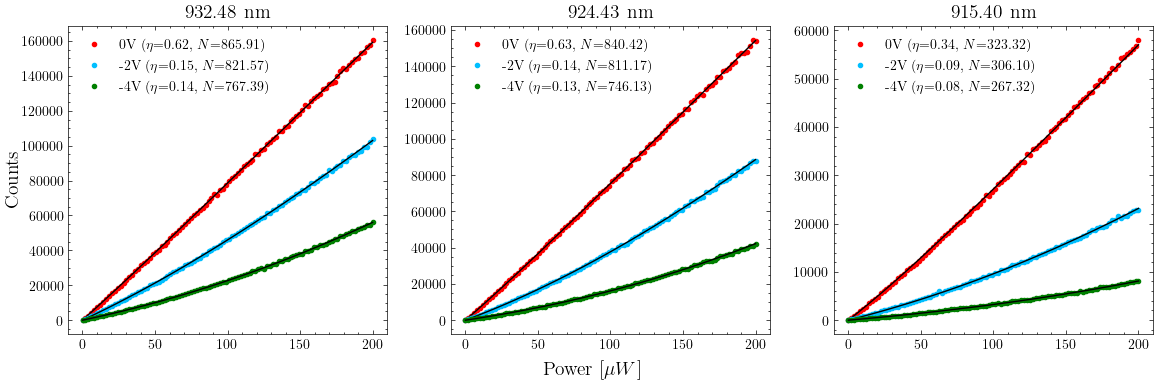

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
colors = ["red", "deepskyblue", "green"]
for i, freq_idx in enumerate([0, 14, 30]):
    for j, voltage in enumerate([0, -2, -4]):
        fit_input = a[j, i]
        fit_result = b[j,i]
        wls = 2.99792458e5 / freqlist

        axs[i].plot(fit_input.xdata, fit_input.ydata, '.', label=fr"{voltage:.0f}V   ($\eta$={fit_result.parameters[0]:.2f}, $N$={fit_result.parameters[1]:.2f})", color=colors[j])
        axs[i].plot(fit_input.xdata, fit_input.fit_func(fit_input.xdata, *fit_result.parameters), color="black")
    axs[i].set_title(f"{wls[freq_idx]:.2f} nm", fontsize=14)
    axs[i].legend()
fig.text(0.5, 0.01, r"Power [$\mu W$]", ha="center", fontsize=14)
fig.text(0.08, 0.5, "Counts", va="center", rotation="vertical", fontsize=14)
# savefig(NB_NAME, "power_counts_three_Vw_97p5k", fig)
plt.show()

In [15]:
a, b, c, d = pf_power_counts_fit(data_dict, 552_000, voltages, powerlist, freq_indices=[0, 14, 30])

/home/ali/Code/Master's project/data_analysis/utilities.py:144: RuntimeWarning: invalid value encountered in power
  beta1 = 1.1e5 * (Eg - Eph) * (2 * mu1) ** (1 / 3) * F ** (-2 / 3)
/home/ali/Code/Master's project/data_analysis/utilities.py:145: RuntimeWarning: invalid value encountered in power
  beta2 = 1.1e5 * (Eg - Eph) * (2 * mu2) ** (1 / 3) * F ** (-2 / 3)
/home/ali/Code/Master's project/data_analysis/utilities.py:158: RuntimeWarning: invalid value encountered in power
  FKa = (a1 + a2) * F ** (1 / 3) * 1e4 / n
/home/ali/Code/Master's project/data_analysis/utilities.py:226: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  alpha = fsolve(func, self.alphas[-1])[0]


Fit with resistance 552000, voltage 0 and wavelength 924.4293957237956 was not completely successful.


KeyboardInterrupt: 

NameError: name 'a' is not defined

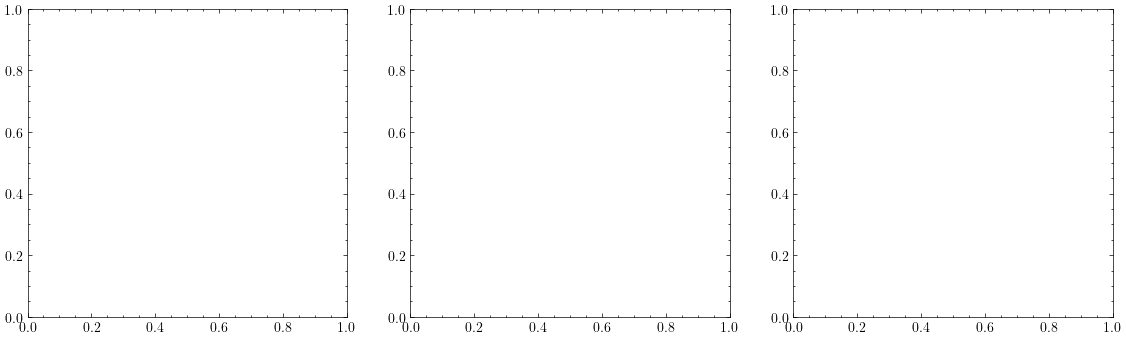

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
colors = ["red", "deepskyblue", "green"]
for i, freq_idx in enumerate([0, 14, 30]):
    for j, voltage in enumerate([0, -2, -4]):
        fit_input = a[j,i]
        fit_result = b[j,i]
        wls = 2.99792458e5 / freqlist

        axs[i].plot(fit_input.xdata, fit_input.ydata, '.', label=fr"{voltage:.0f}V   ($\eta$={fit_result.parameters[0]:.2f}, $\alpha_0$={fit_result.parameters[1]:.2f})", color=colors[j])
        axs[i].plot(fit_input.xdata, fit_input.fit_func(fit_input.xdata, *fit_result.parameters), color="black")
    axs[i].set_title(f"{wls[freq_idx]:.2f} nm", fontsize=14)
    axs[i].legend()
fig.text(0.5, 0.01, r"Power [$\mu W$]", ha="center", fontsize=14)
fig.text(0.08, 0.5, "Counts", va="center", rotation="vertical", fontsize=14)
# savefig(NB_NAME, "power_counts_three_Vw_552k", fig)
plt.show()

In [27]:
a, b, c, d = pf_power_counts_fit(data_dict, 1_000_000, voltages, powerlist, freq_indices=[0, 14, 30])

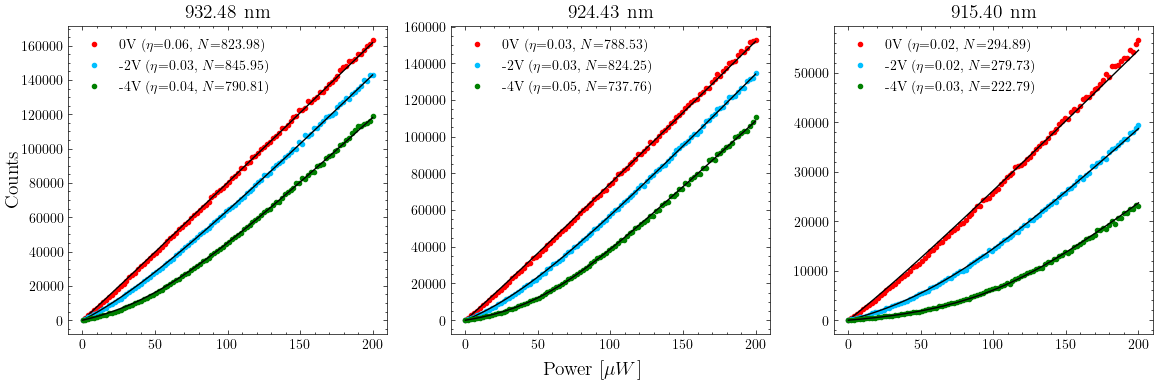

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
colors = ["red", "deepskyblue", "green"]
for i, freq_idx in enumerate([0, 14, 30]):
    for j, voltage in enumerate([0, -2, -4]):
        fit_input = a[j,i]
        fit_result = b[j,i]
        wls = 2.99792458e5 / freqlist

        axs[i].plot(fit_input.xdata, fit_input.ydata, '.', label=fr"{voltage:.0f}V   ($\eta$={fit_result.parameters[0]:.2f}, $N$={fit_result.parameters[1]:.2f})", color=colors[j])
        axs[i].plot(fit_input.xdata, fit_input.fit_func(fit_input.xdata, *fit_result.parameters), color="black")
    axs[i].set_title(f"{wls[freq_idx]:.2f} nm", fontsize=14)
    axs[i].legend()
fig.text(0.5, 0.01, r"Power [$\mu W$]", ha="center", fontsize=14)
fig.text(0.08, 0.5, "Counts", va="center", rotation="vertical", fontsize=14)
# savefig(NB_NAME, "power_counts_three_Vw_1M", fig)
plt.show()

In [ ]:
for resistance in resistances:
    if resistance == 0:
        continue
    print(f"PLOTS FOR RESISTANCE {resistance:,}")
    inputs, results, nl_coeffs, nl_pows = pf_power_counts_fit(data_dict, resistance, voltages, powerlist, range(0, len(freqlist), 2))

    nl_coeffs_0V, nl_coeffs_m2V, nl_coeffs_m4V = nl_coeffs
    nl_pows_0V, nl_pows_m2V, nl_pows_m4V = nl_pows

    plot_power_counts_with_fit(inputs, results, voltages)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    ax1.plot(freqlist[::2], nl_coeffs_0V, '.-', label="0V")
    ax1.plot(freqlist[::2], nl_coeffs_m2V, '.-', label="-2V")
    ax1.plot(freqlist[::2], nl_coeffs_m4V, '.-', label="-4V")
    ax1.set_xlabel(r"Frequency [THz]", fontsize=14)
    ax1.set_ylabel("Non-linearity coefficient", fontsize=14)
    ax1.legend(frameon=False, fontsize=13)

    ax2.plot(freqlist[::2], nl_pows_0V, '.-', label="0V")
    ax2.plot(freqlist[::2], nl_pows_m2V, '.-', label="-2V")
    ax2.plot(freqlist[::2], nl_pows_m4V, '.-', label="-4V")
    ax2.set_xlabel(r"Frequency [THz]", fontsize=14)
    ax2.set_ylabel("Power at peak non-linearity [$\mu W$]", fontsize=14)
    ax2.legend(frameon=False, fontsize=13)

    plt.show()


PLOTS FOR RESISTANCE 97,500


KeyboardInterrupt: 

[0.06290325214298262, 868.1375387732169]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.056257628349415514, 654.1314888406399]
[0.030220507841925245, 300.00000027815247]


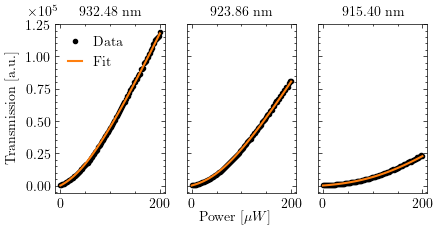

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(4.8, 2.2), sharey=True)
res_idx = 6
for i, wl_idx in enumerate([0, 15, 30]):
    fk_fit = FKFit(
        powerlist,
        resistances[res_idx] * 1e-6,
        3.5e-3,
        wls[wl_idx],
        0.0,
        298,
        -4,
    )
    fit_input = FitInput(
        powerlist,
        data_dict[resistances[res_idx]][-4]["counts"][wl_idx],
        np.sqrt(data_dict[resistances[res_idx]][-4]["counts"][wl_idx]),
        # data_dict[resistances[res_idx]][-4]["counts"][wl_idx] * 0.02,
        fk_fit.FK_fit_power_scaled,
        [0.01, 600],
    )
    fit_result = perform_fit(
        fit_input, bounds={"eta": [0, 1], "norm": [300, 1000]}
    )

    print(fit_result.parameters)

    if i == 0:
        label1 = "Data"
        label2 = "Fit"
    else:
        label1 = ""
        label2 = ""
    
    axs[i].plot(
        fit_input.xdata,
        fit_input.ydata / 1e5,
        ".",
        color="black",
        label=label1,
    )

    axs[i].plot(
        fit_input.xdata,
        fit_input.fit_func(fit_input.xdata, *fit_result.parameters) / 1e5,
        color="tab:orange",
        lw=1.5,
        label=label2,
    )

    axs[i].set_title(f"{wls[wl_idx]:.2f} nm", fontsize=10)


    axs[i].legend(fontsize=10, frameon=False, handlelength=1.0)
fig.supxlabel(r"Power [$\mu W$]", fontsize=10, y=-0.03)
fig.supylabel(r"Transmission [a.u.]", fontsize=10)
fig.text(0.07, 0.925, r"$\times 10^{5}$")
# savefig(NB_NAME, "nl_transmission_wls", fig, svg=True)
plt.show()

[0.09101887674366986, 812.8850675681664]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.07907597656912485, 569.8951586854216]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.03633866925958303, 300.00000000379237]


Text(0.07, 0.925, '$\\times 10^{5}$')

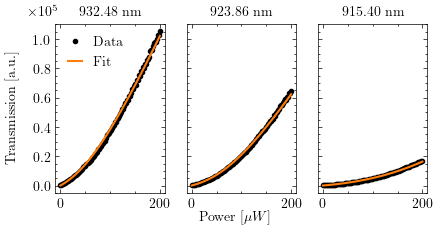

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(4.8, 2.2), sharey=True)
res_idx = 3
for i, wl_idx in enumerate([0, 15, 30]):
    fk_fit = FKFit(
        powerlist,
        resistances[res_idx] * 1e-6,
        3.5e-3,
        wls[wl_idx],
        0.0,
        298,
        -4,
    )
    fit_input = FitInput(
        powerlist,
        data_dict[resistances[res_idx]][-4]["counts"][wl_idx],
        np.sqrt(data_dict[resistances[res_idx]][-4]["counts"][wl_idx]),
        # data_dict[resistances[res_idx]][-4]["counts"][wl_idx] * 0.02,
        fk_fit.FK_fit_power_scaled,
        [0.01, 600],
    )
    fit_result = perform_fit(
        fit_input, bounds={"eta": [0, 1], "norm": [300, 1000]}
    )

    print(fit_result.parameters)

    if i == 0:
        label1 = "Data"
        label2 = "Fit"
    else:
        label1 = ""
        label2 = ""
    
    axs[i].plot(
        fit_input.xdata,
        fit_input.ydata / 1e5,
        ".",
        color="black",
        label=label1,
    )

    axs[i].plot(
        fit_input.xdata,
        fit_input.fit_func(fit_input.xdata, *fit_result.parameters) / 1e5,
        color="tab:orange",
        lw=1.5,
        label=label2,
    )

    axs[i].set_title(f"{wls[wl_idx]:.2f} nm", fontsize=10)


    axs[i].legend(fontsize=10, frameon=False, handlelength=1.0)
fig.supxlabel(r"Power [$\mu W$]", fontsize=10, y=-0.03)
fig.supylabel(r"Transmission [a.u.]", fontsize=10)
fig.text(0.07, 0.925, r"$\times 10^{5}$")

[0.1398901080932308, 767.3935650682994]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.12279080145138781, 581.7439906303483]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.054058532397504105, 300.00000000000085]


Text(0.07, 0.925, '$\\times 10^{5}$')

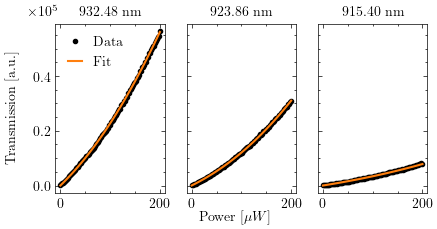

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(4.8, 2.2), sharey=True)
res_idx = 1
for i, wl_idx in enumerate([0, 15, 30]):
    fk_fit = FKFit(
        powerlist,
        resistances[res_idx] * 1e-6,
        3.5e-3,
        wls[wl_idx],
        0.0,
        298,
        -4,
    )
    fit_input = FitInput(
        powerlist,
        data_dict[resistances[res_idx]][-4]["counts"][wl_idx],
        np.sqrt(data_dict[resistances[res_idx]][-4]["counts"][wl_idx]),
        # data_dict[resistances[res_idx]][-4]["counts"][wl_idx] * 0.02,
        fk_fit.FK_fit_power_scaled,
        [0.01, 600],
    )
    fit_result = perform_fit(
        fit_input, bounds={"eta": [0, 1], "norm": [300, 1000]}
    )

    print(fit_result.parameters)

    if i == 0:
        label1 = "Data"
        label2 = "Fit"
    else:
        label1 = ""
        label2 = ""
    
    axs[i].plot(
        fit_input.xdata,
        fit_input.ydata / 1e5,
        ".",
        color="black",
        label="Data",
    )

    axs[i].plot(
        fit_input.xdata,
        fit_input.fit_func(fit_input.xdata, *fit_result.parameters) / 1e5,
        color="tab:orange",
        lw=1.5,
        label="Fit",
    )

    axs[i].set_title(f"{wls[wl_idx]:.2f} nm", fontsize=10)


    axs[i].legend(fontsize=10, frameon=False, handlelength=1.0)
fig.supxlabel(r"Power [$\mu W$]", fontsize=10, y=-0.03)
fig.supylabel(r"Transmission [a.u.]", fontsize=10)
fig.text(0.07, 0.925, r"$\times 10^{5}$")

Text(0, 0.5, 'Transmission [a.u.]')

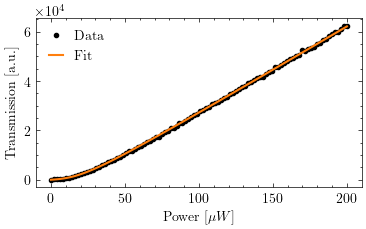

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(4.2, 2.2))
res_idx = -1
wl_idx = -1
fk_fit = FKFit(
    powerlist,
    resistances[res_idx] * 1e-6,
    3.5e-3,
    wls[wl_idx],
    0.0,
    298,
    -4,
)

fit_input = FitInput(
    powerlist,
    data_dict[resistances[res_idx]][-4]["counts"][wl_idx],
    np.sqrt(data_dict[resistances[res_idx]][-4]["counts"][wl_idx]),
    # data_dict[resistances[res_idx]][-4]["counts"][wl_idx] * 0.015,
    fk_fit.FK_fit_power_scaled,
    [0.01, 600],
)
fit_result = perform_fit(
    fit_input, bounds={"eta": [0, 1], "norm": [300, 1000]}
)
    
axs.plot(
    fit_input.xdata,
    fit_input.ydata,
    ".",
    color="black",
    label="Data",
)

axs.plot(
    fit_input.xdata,
    fit_input.fit_func(fit_input.xdata, *fit_result.parameters),
    color="tab:orange",
    lw=1.5,
    label="Fit",
)
axs.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs.legend(fontsize=10, frameon=False, handlelength=1.0)
axs.set_xlabel(r"Power [$\mu W$]", fontsize=10, y=-0.03)
axs.set_ylabel(r"Transmission [a.u.]", fontsize=10)
# savefig(NB_NAME, "nl_transmission_10Mohm", fig, svg=True)

In [231]:
def relu_fit(x, a, b):
    return a * np.array([max([x_val - b, 0]) for x_val in x])

def leaky_relu_fit(x, a, b, c):
    return np.piecewise(x, [x < b, x >= b], [lambda x: c * x, lambda x: c * x + a * (x - b)])

# def softplus_fit(x, a, b, c):
#     return np.logaddexp(0, a*(x-b)) + c

def softplus_fit(x, a, b):
    softplus = np.logaddexp(0, a * (x -  b)) 
    return softplus - np.min(softplus)

Text(0, 0.5, 'Transmission [a.u.]')

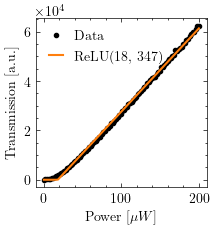

In [232]:
fig, axs = plt.subplots(1, 1, figsize=(2.2, 2.2))
res_idx = -1
wl_idx = -1

fit_input = FitInput(
    powerlist,
    data_dict[resistances[res_idx]][-4]["counts"][wl_idx],
    np.sqrt(data_dict[resistances[res_idx]][-4]["counts"][wl_idx]),
    # np.mean(data_dict[resistances[res_idx]][-4]["counts"][wl_idx]) * 0.015,
    # leaky_relu_fit,
    # [247.69398169753183, 25.739864867937154, 91.59263613650556],
    relu_fit,
    [336.60526402031456, 17.947739536633765],
)
fit_result = perform_fit_rounds(fit_input, opt_rounds=10, softloss=True)
    
axs.plot(
    fit_input.xdata,
    fit_input.ydata,
    ".",
    color="black",
    label="Data",
)
axs.plot(
    fit_input.xdata,
    fit_input.fit_func(fit_input.xdata, *fit_result.parameters),
    label="ReLU(18, 347)",
    lw=1.5,
    color="tab:orange",
)
# axs.plot(np.linspace(0, 200, 10_000), leaky_relu_fit(np.linspace(0, 200, 10_000), 1e2, 9, 50))
axs.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs.legend(fontsize=10, frameon=False, handlelength=1.0)
axs.set_xlabel(r"Power [$\mu W$]", fontsize=10, y=-0.03)
axs.set_ylabel(r"Transmission [a.u.]", fontsize=10)
# axs.set_xlim(0, 50)
# axs.set_ylim(0, 3000)
# savefig(NB_NAME, "relu_fit", fig, svg=True)

In [233]:
wls

array([932.48042924, 931.90070873, 931.32170861, 930.74342751,
       930.1658641 , 929.58901705, 929.01288503, 928.43746671,
       927.86276076, 927.28876585, 926.71548068, 926.14290392,
       925.57103427, 924.99987041, 924.42941104, 923.85965485,
       923.29060055, 922.72224685, 922.15459243, 921.58763603,
       921.02137634, 920.4558121 , 919.89094201, 919.3267648 ,
       918.76327919, 918.20048392, 917.63837772, 917.07695931,
       916.51622745, 915.95618087, 915.39681832])

In [234]:
resistances

[0, 97500, 325300, 552000, 677000, 807000, 1000000, 3012000, 10000000]

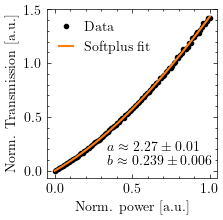

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(2.2, 2.2), sharey=True)
norm = 44105
res_idx = 1
wl_idx = 4

fit_input = FitInput(
    powerlist / 200,
    data_dict[resistances[res_idx]][-4]["counts"][wl_idx] / norm,
    # np.sqrt(data_dict[resistances[1]][-4]["counts"][4]) / np.max(data_dict[resistances[1]][-4]["counts"][4]),
    # np.mean(data_dict[resistances[res_idx]][-4]["counts"][wl_idx]) * 0.015 / norm,
    data_dict[resistances[res_idx]][-4]["counts"][wl_idx] * 0.015 / norm,
    # leaky_relu_fit,
    # [247.69398169753183, 25.739864867937154, 91.59263613650556],
    softplus_fit,
    [2, 0.1],
)
fit_result = perform_fit_rounds(fit_input, opt_rounds=10, softloss=True)
    
axs.plot(
    fit_input.xdata,
    fit_input.ydata,
    ".",
    color="black",
    label="Data",
)
axs.plot(
    fit_input.xdata,
    fit_input.fit_func(fit_input.xdata, *fit_result.parameters),
    label="Softplus fit",
    lw=1.5,
    color="tab:orange",
)
params_latex_strings = [
    fr"$a \approx$ {num_err_to_latex_str(fit_result.parameters[0], fit_result.parameter_errors[0])}",
    fr"$b \approx$ {num_err_to_latex_str(fit_result.parameters[1], fit_result.parameter_errors[1])}",
    ]
# axs.plot(np.linspace(0, 200, 10_000) / 200, softplus_fit(np.linspace(0, 200, 10_000) / 200, 2, 0.1, -0.8))
axs.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs.legend(fontsize=10, frameon=False, handlelength=1.0)
axs.set_xlabel(r"Norm. power [a.u.]", fontsize=10, y=-0.03)
axs.set_ylabel(r"Norm. Transmission [a.u.]", fontsize=10)
axs.text(0.97, 0.15, "\n".join(params_latex_strings), ma="left", va="center", ha="right", fontsize=10, transform=axs.transAxes)
# savefig(NB_NAME, "softplus_fit_100k", fig, svg=True)

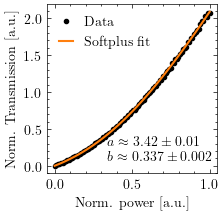

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(2.2, 2.2), sharey=True)
norm = 44105
res_idx = 2
wl_idx = 4

fit_input = FitInput(
    powerlist / 200,
    data_dict[resistances[res_idx]][-4]["counts"][wl_idx] / norm,
    # np.sqrt(data_dict[resistances[1]][-4]["counts"][4]) / np.max(data_dict[resistances[1]][-4]["counts"][4]),
    # np.mean(data_dict[resistances[res_idx]][-4]["counts"][wl_idx]) * 0.015 / norm,
    data_dict[resistances[res_idx]][-4]["counts"][wl_idx] * 0.015 / norm,
    # leaky_relu_fit,
    # [247.69398169753183, 25.739864867937154, 91.59263613650556],
    softplus_fit,
    [2, 0.1],
)
fit_result = perform_fit_rounds(fit_input, opt_rounds=10, softloss=True)
    
axs.plot(
    fit_input.xdata,
    fit_input.ydata,
    ".",
    color="black",
    label="Data",
)
axs.plot(
    fit_input.xdata,
    fit_input.fit_func(fit_input.xdata, *fit_result.parameters),
    label="Softplus fit",
    lw=1.5,
    color="tab:orange",
)
params_latex_strings = [
    fr"$a \approx$ {num_err_to_latex_str(fit_result.parameters[0], fit_result.parameter_errors[0])}",
    fr"$b \approx$ {num_err_to_latex_str(fit_result.parameters[1], fit_result.parameter_errors[1])}",
    ]
# axs.plot(np.linspace(0, 200, 10_000) / 200, softplus_fit(np.linspace(0, 200, 10_000) / 200, 2, 0.1, -0.8))
axs.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs.legend(fontsize=10, frameon=False, handlelength=1.0)
axs.set_xlabel(r"Norm. power [a.u.]", fontsize=10, y=-0.03)
axs.set_ylabel(r"Norm. Transmission [a.u.]", fontsize=10)
axs.text(0.97, 0.15, "\n".join(params_latex_strings), ma="left", va="center", ha="right", fontsize=10, transform=axs.transAxes)
# savefig(NB_NAME, "softplus_fit_300k", fig, svg=True)

In [322]:
resistances[2]

325300

In [ ]:
norm = 44105
wl_idx = 4

fit_results_softplus_wavelengths = []

for wl_idx in range(len(wls)):
    fit_results_softplus_resistances = []

    for res_idx in range(len(resistances[:-2])):
        fit_input = FitInput(
            powerlist / 200,
            data_dict[resistances[res_idx]][-4]["counts"][wl_idx] / norm,
            # np.sqrt(data_dict[resistances[1]][-4]["counts"][4]) / np.max(data_dict[resistances[1]][-4]["counts"][4]),
            np.mean(data_dict[resistances[res_idx]][-4]["counts"][wl_idx]) * 0.015 / norm,
            # leaky_relu_fit,
            # [247.69398169753183, 25.739864867937154, 91.59263613650556],
            softplus_fit,
            [2, 0.1],
        )
        fit_result = perform_fit_rounds(fit_input, opt_rounds=10, softloss=True)

        fit_results_softplus_resistances.append(fit_result)

    fit_results_softplus_wavelengths.append(fit_results_softplus_resistances)

fit_results_softplus_wavelengths = np.array(fit_results_softplus_wavelengths)

In [275]:
a_2d_scan = np.array([res.parameters[0] for res in fit_results_softplus_wavelengths.ravel()]).reshape(31, 7)
b_2d_scan = np.array([res.parameters[1] for res in fit_results_softplus_wavelengths.ravel()]).reshape(31, 7)

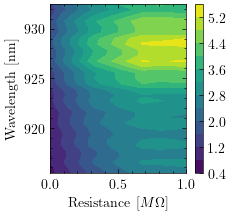

In [ ]:
fig = plt.figure(figsize=(2.2,2.2))
plt.contourf(np.array(resistances[:-2]) * 1e-6, wls, a_2d_scan, levels=11)
plt.xlabel("Resistance [$M\Omega$]", fontsize=10)
plt.ylabel("Wavelength [nm]", fontsize=10)
plt.colorbar()
# savefig(NB_NAME, "a_2d_scan", fig, svg=True)

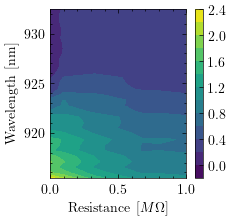

In [ ]:
fig = plt.figure(figsize=(2.2,2.2))
plt.contourf(np.array(resistances[:-2]) * 1e-6, wls, b_2d_scan, levels=11)
plt.xlabel("Resistance [$M\Omega$]", fontsize=10)
plt.ylabel("Wavelength [nm]", fontsize=10)
plt.colorbar()
# savefig(NB_NAME, "b_2d_scan", fig, svg=True)